In [32]:
import ase.io
import numpy as np
import copy
import matplotlib.pyplot as plt
import functools 
import torch

In [64]:
frames = ase.io.read('./gp_iter6_sparse9k.xml.xyz', ':')

# Preprocessing dataset

In [65]:
print(len(frames))

2475


## get energy (eV)

In [66]:
frames = [frame for frame in frames if ('dft_energy' in frame.info.keys()) or ('DFT_energy' in frame.info.keys())]
print(len(frames))

2475


## dress energies (atom 1 is isolated atom energy) and convert to eV/atom

In [67]:
dressed_energies_per_atom = []
# energy of one isolated Si atom
baseline_energy = frames[0].info['dft_energy'] 
for frame in frames:
    energy = frame.info['dft_energy'] if ('dft_energy' in frame.info.keys()) else frame.info['DFT_energy']
    frame.info['energy'] = energy
    energy -= baseline_energy*len(frame)
    frame.info['dressed_energy'] = energy
    energy /= len(frame)
    frame.info['dressed_energy_per_atom'] = energy
    dressed_energies_per_atom.append( energy )
frames = frames[1:] # the first structure causes high error
print(len(frames))

2474


In [68]:
dressed_energies_per_atom = np.array(dressed_energies_per_atom)

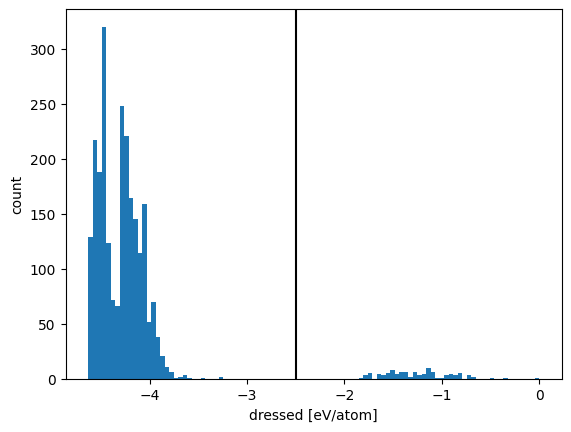

In [69]:
plt.hist(dressed_energies_per_atom, bins=100)
plt.axvline(-2.5, color='black')
plt.xlabel('dressed [eV/atom]')
plt.ylabel('count')
plt.show()
plt.close()

## Remove everything above -2.5, causes the error to be to dependent on the train-test split

In [70]:
frames = [frame for frame in frames if frame.info['dressed_energy_per_atom'] < -2.5]
dressed_energies_per_atom = np.array([frame.info['dressed_energy_per_atom'] for frame in frames])

In [71]:
print(len(frames))

2374


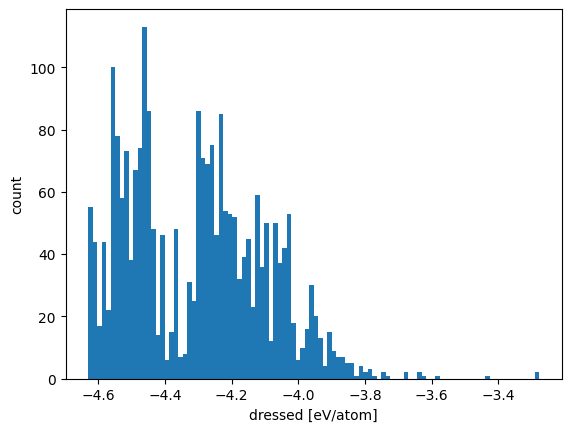

In [73]:
plt.hist(dressed_energies_per_atom, bins=100)
plt.xlabel('dressed [eV/atom]')
plt.ylabel('count')
plt.show()
plt.close()

## Center 

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False).fit(dressed_energies_per_atom.reshape(-1,1))
scaled_dressed_energies_per_atom = scaler.transform(dressed_energies_per_atom.reshape(-1,1)).reshape(-1)
for i, frame in enumerate(frames):
    frame.info['scaled_dressed_energies_per_atom'] = scaled_dressed_energies_per_atom[i]


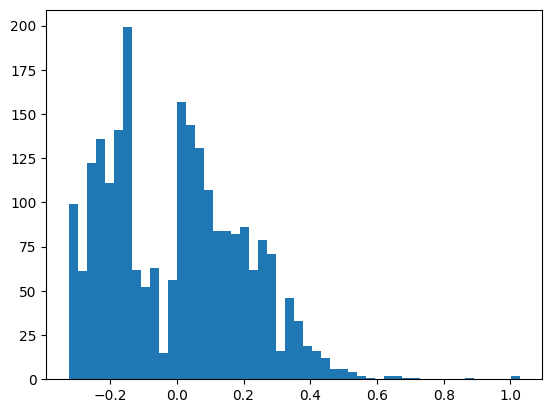

In [76]:
plt.hist(scaled_dressed_energies_per_atom, bins=50)
plt.show()
plt.close()

# utils

In [77]:
from collections import defaultdict

import numpy as np
import torch
from typing import Dict, List, Tuple, TypeVar, Callable, Optional
import ase

import abc
AtomicStructure = TypeVar('AtomicStructure')

def structure_to_torch(structure : AtomicStructure,
        device : Optional[torch.device] = None,
        dtype: Optional[torch.dtype] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    :returns:
        Tuple of posititions, species, cell and periodic boundary conditions
    """
    if isinstance(structure, ase.Atoms):
        # dtype is automatically referred from the type in the structure object if None
        positions = torch.tensor(structure.positions, device=device, dtype=dtype)
        species = torch.tensor(structure.numbers, device=device)
        cell = torch.tensor(structure.cell.array, device=device, dtype=dtype)
        pbc = torch.tensor(structure.pbc, device=device)
        return positions, species, cell, pbc
    else:
        raise ValueError("Unknown atom type. We only support ase.Atoms at the moment.")

def build_neighborlist(positions: torch.Tensor, cell: torch.Tensor, pbc: torch.Tensor, cutoff : float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    assert positions.device == cell.device
    assert positions.device == pbc.device
    device = positions.device

    # will be replaced with something with GPU support
    pairs_i, pairs_j, cell_shifts = ase.neighborlist.primitive_neighbor_list(
        quantities="ijS",
        positions=positions.detach().cpu().numpy(),
        cell=cell.detach().cpu().numpy(),
        pbc=pbc.detach().cpu().numpy(),
        cutoff=cutoff,
        self_interaction=False,
        use_scaled_positions=False,
    )
    pairs_i = torch.tensor(pairs_i, device=device)
    pairs_j = torch.tensor(pairs_j, device=device)
    cell_shifts = torch.tensor(cell_shifts, device=device)

    pairs = torch.vstack([pairs_i, pairs_j]).T
    centers = torch.arange(len(positions), device=device)
    return centers, pairs, cell_shifts


class TransformerBase(metaclass=abc.ABCMeta):
    """
    Abstract class for extracting information of an AtomicStructure objects and processing it
    """
    @abc.abstractmethod
    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        pass

class TransformerProperty(TransformerBase):
    """
    Extracts property information out of an AtomicStructure using a function given as input
    """
    def __init__(self, property_name: List[str], get_property: List[Callable[[AtomicStructure], torch.Tensor]],
            device=None, dtype=None):
        if not(isinstance(get_property, list)):
            property_name = [property_name]
        if not(isinstance (get_property, list)):
            get_property = [get_property]
        self._get_property = get_property
        self._property_name = property_name
        self._device = device
        self._dtype = dtype


    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        return {self._property_name[i]: self._get_property[i](structure).to(device=self._device, dtype=self._dtype)
                for i in range(len(self._property_name))}

class TransformerNeighborList(TransformerBase):
    """
    Produces a neighbour list and with direction vectors from an AtomicStructure
    """
    def __init__(self, cutoff: float, device=None, dtype=None):
        self._cutoff = cutoff
        self._device = device
        self._dtype = dtype

    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        positions_i, species_i, cell_i, pbc_i = structure_to_torch(structure,
                dtype=self._dtype, device=self._device)
        centers_i, pairs_ij, cell_shifts_ij = build_neighborlist(positions_i, cell_i,
                pbc_i, self._cutoff)

        return {
            'positions': positions_i,
            'species': species_i,
            'cell': cell_i,
            'centers': centers_i,
            'pairs': pairs_ij,
            'cell_shifts': cell_shifts_ij
        }

# Temporary Dataset until we have an metatensor Dataset
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self,
                 structures : List[AtomicStructure],
                 transformers : List[TransformerBase]):
        super().__init__()
        self.n_structures = len(structures)
        self._data = defaultdict(list)
        for structure in structures:
            for transformer in transformers:
                data_i = transformer(structure)
                for key in data_i.keys():
                    self._data[key].append(data_i[key])

    def __getitem__(self, idx):
        return {key: self._data[key][idx] for key in self._data.keys()}

    def __len__(self):
        return self.n_structures

def collate_nl(data_list, device=None, dtype=None):

    collated = {key: torch.concatenate([data[key].to(device=device) for data in data_list], dim=0)
                for key in filter(lambda x : x not in ["positions", "cell"], data_list[0].keys())}
    collated['positions'] = torch.concatenate([data["positions"] for data in data_list]).to(dtype=dtype, device=device)
    collated['cells'] = torch.stack([data["cell"] for data in data_list]).to(dtype=dtype, device=device)
    collated['structure_centers'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["centers"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_pairs'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["pairs"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_offsets'] = torch.tensor(
        np.cumsum([0] + [structure_data["positions"].shape[0] for structure_data in data_list[:-1]]),
        device=collated["positions"][0].device,
        dtype=torch.long
    ).to(device=device)

    return collated

def get_dressed_energy_per_atom(frame) -> torch.Tensor:
    return torch.tensor([frame.info['scaled_dressed_energies_per_atom']])

In [156]:
from torch import nn
import math

class CosineCutoff(nn.Module):
    r""" Behler-style cosine cutoff module.

    .. math::
       f(r) = \begin{cases}
        0.5 \times \left[1 + \cos\left(\frac{\pi r}{r_\text{cutoff}}\right)\right]
          & r < r_\text{cutoff} \\
        0 & r \geqslant r_\text{cutoff} \\
        \end{cases}

    """

    def __init__(self, cutoff: float):
        """
        Args:
            cutoff (float, optional): cutoff radius.
        """
        super(CosineCutoff, self).__init__()
        self.register_buffer("cutoff", torch.FloatTensor([cutoff]))

    def forward(self, input: torch.Tensor):
        return cosine_cutoff(input, self.cutoff)

def cosine_cutoff(input: torch.Tensor, cutoff: torch.Tensor):
    """ Behler-style cosine cutoff.

        .. math::
           f(r) = \begin{cases}
            0.5 \times \left[1 + \cos\left(\frac{\pi r}{r_\text{cutoff}}\right)\right]
              & r < r_\text{cutoff} \\
            0 & r \geqslant r_\text{cutoff} \\
            \end{cases}

        Args:
            cutoff (float, optional): cutoff radius.

        """

    # Compute values of cutoff function
    input_cut = 0.5 * (torch.cos(input * math.pi / cutoff) + 1.0)
    # Remove contributions beyond the cutoff radius
    input_cut *= (input < cutoff).float()
    return input_cut


class GaussianRBF(nn.Module):
    r"""Gaussian radial basis functions."""

    def __init__(
        self, n_rbf: int, cutoff: float, start: float = 0.0, sigma: float = None ,trainable: bool = False
    ):
        """
        Args:
            n_rbf: total number of Gaussian functions, :math:`N_g`.
            cutoff: center of last Gaussian function, :math:`\mu_{N_g}`
            start: center of first Gaussian function, :math:`\mu_0`.
            trainable: If True, widths and offset of Gaussian functions
                are adjusted during training process.
        """
        super(GaussianRBF, self).__init__()
        self.n_rbf = n_rbf

        # compute offset and width of Gaussian functions
        offset = torch.linspace(start, cutoff, n_rbf)
        if sigma is None:
            widths = torch.FloatTensor(
                torch.abs(offset[1] - offset[0]) * torch.ones_like(offset)
            )
        else:
            widths = sigma *  torch.ones_like(offset)
        if trainable:
            self.widths = nn.Parameter(widths)
            self.offsets = nn.Parameter(offset)
        else:
            self.register_buffer("widths", widths)
            self.register_buffer("offsets", offset)

    def forward(self, inputs: torch.Tensor):
        return gaussian_rbf(inputs, self.offsets, self.widths)

def gaussian_rbf(inputs: torch.Tensor, offsets: torch.Tensor, widths: torch.Tensor):
    coeff = -0.5 / torch.pow(widths, 2)
    diff = inputs[..., None] - offsets
    midcoeff = coeff * torch.pow(diff, 2)
    y = torch.exp(midcoeff)
    # approximation of exp, because of gradient bug
    #y = 1+midcoeff+(midcoeff**2)/2+(midcoeff**3)/6+(midcoeff**4)/24+(midcoeff**5)/120
    return y

class Embedding(nn.Module):

    def __init__(
        self, feature_size: int, cutoff: float, cutoff_fn: bool = True, sigma: float = None, trainable:bool = False
    ):
        super().__init__()
        self._feature_size = feature_size
        self._cutoff = cutoff
        self._expansion = GaussianRBF(n_rbf=feature_size, cutoff=cutoff, trainable=trainable, sigma=sigma)
        self._cutoff_module = CosineCutoff(cutoff)
        self._cutoff_fn = cutoff_fn

    def forward(self, r: torch.Tensor):
        x = self._expansion(r)
        if self._cutoff_fn:
            x *= self._cutoff_module(r).unsqueeze(-1)
        return x


In [79]:
x = np.linspace(0,CUTOFF,100)
plt.plot(x, 1+x+(x**2)/2+(x**3)/6+(x**4)/24+(x**5)/120)
plt.show()
plt.close()

NameError: name 'CUTOFF' is not defined

In [80]:

def get_cartesian_vectors(positions,
                          cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets):
    """
    Wraps direction vectors into TensorBlock object with metadata information
    """

    # calculate interatomic vectors
    pairs_offsets = structure_offsets[structure_pairs]
    shifted_pairs = pairs_offsets[:, None] + pairs
    shifted_pairs_i = shifted_pairs[:, 0]
    shifted_pairs_j = shifted_pairs[:, 1]
    direction_vectors = positions[shifted_pairs_j] - positions[shifted_pairs_i] + torch.einsum("ab, abc -> ac", cell_shifts.to(cells.dtype), cells[structure_pairs])

    # find associated metadata
    #pairs_i = pairs[:, 0]
    #pairs_j = pairs[:, 1]
    #labels = torch.stack([
    #    structure_pairs,
    #    pairs_i,
    #    pairs_j,
    #    species[shifted_pairs_i],
    #    species[shifted_pairs_j],
    #    cell_shifts[:, 0],
    #    cell_shifts[:, 1],
    #    cell_shifts[:, 2]
    #], dim=-1)
    return direction_vectors

# Globals for prototyping

In [81]:
CUTOFF = 6.
#torch.set_default_device("cuda:0")
DTYPE = torch.float32
DEVICE = "cuda"
collate_nl_and_move = functools.partial(collate_nl, dtype=DTYPE, device=DEVICE)

### some debug

In [82]:
dataset = InMemoryDataset(frames[:200],
                          [TransformerNeighborList(cutoff=CUTOFF),
                           TransformerProperty("scaled_dressed_energies_per_atom", get_dressed_energy_per_atom)])

In [83]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_nl, shuffle=False)

In [84]:
next(iter(dataloader))

{'species': tensor([14, 14]),
 'centers': tensor([0, 0]),
 'pairs': tensor([[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]

# Model - Spliney

## center and neighbor are separate interaction blocks (used for final experiment)

In [312]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                self_interaction: int = 5,
                neighbor_interaction: int = 0,
                sigma: float = None,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._self_interaction = self_interaction
        self._neighbor_interaction = neighbor_interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, sigma=sigma)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._self_interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._neighbor_interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._self_interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._neighbor_interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            pair_E = pair_E * center_w[pairs_i]
                    
        for i in range(len(self._neighbor_interaction_layers)):
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)
            
            # new representation is computed
            pair_x = self._neighbor_interaction_layers[i](embedding)
            pair_E = self._neighbor_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            pair_E = pair_E * center_w[pairs_j]
            
        
        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## center and neighbor are merged to one interaction block (prototype not used in final experiment)

In [305]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 0,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._layers2 = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])

        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)

            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            pair_E = pair_E + center_w[pairs_i]
                    
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)
            
            # new representation is computed
            pair_x = self._neighbor_interaction_layers[i](embedding)
            pair_E = self._neighbor_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            pair_E = pair_E * center_w[pairs_j]

        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## center and neighbor are merged to one interaction block - center and neighbor use same repr (prototype not used in final experiment)

In [659]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 0,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)

            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            pair_E = pair_E * center_w[pairs_i]
            pair_E = pair_E * center_w[pairs_j]
            
        
        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

# Model PointEdge

In [414]:
from copy import deepcopy

class PointEdge(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 1,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False)
        self._embedding.to(device=device, dtype=dtype)
        self._embeddings = torch.nn.Sequential(*[
                    Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False)
        for i in range(self._interaction)])
        self._embeddings.to(device=device, dtype=dtype)
        
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._layer_linear = torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)

        self._center_layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._center_layer_linear = torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
        
        # TODO rename to input_layers
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._center_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])

        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])
        self._center_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)
        pair_x = embedding
        #pair_x = self._layers(pair_x)
        #pair_x = self._layer_linear(pair_x)
        # this pair_E_x is splined
        #pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
        center_x = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
            0, pairs_i, pair_x)
        #center_x = self._center_layers(center_x)
        #center_x = self._center_interaction_linear_layers(center_x)

        for i in range(self._interaction):
            # central representation becomes weight
            #center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            #center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            # new representation is computed
            center_w = torch.index_reduce(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x, reduce="mean")
            pair_x = pair_x + center_w[pairs_i]
            pair_x = self._self_interaction_layers[i](pair_x)
            pair_x = self._self_interaction_linear_layers[i](pair_x)
            #pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            
            center_x_ = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x)

            # new representation is computed
            center_x_ = self._neighbor_interaction_layers[i](center_x_)
            center_x_ = self._neighbor_interaction_linear_layers[i](center_x_)
            center_x += center_x_
            center_x = self._center_interaction_layers[i](center_x)
            center_x = self._center_interaction_linear_layers[i](center_x)
            
        center_E = self._output_layer(center_x)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

# Model PairAggregate

In [269]:
class OnlyPairAggregate(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                layers_per_interaction=3,
                feature_size: int = 128,
                sigmas: List[float] = None,
                dtype = None,
                device = None):
        super().__init__()
        if sigmas is None:
            sigmas = [0.1, 0.3, 0.5]
        self._sigmas = sigmas
        self._feature_size = feature_size
        self._embeddings = torch.nn.Sequential(*[
                    Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False, sigma=sigma)
                            for sigma in self._sigmas])
        self._layers_per_interaction = layers_per_interaction

        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in self._sigmas])
        self._output_layers = torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
                                                        for sigma in self._sigmas])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):
        
        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        ys = torch.zeros(len(structure_offsets), len(self._embeddings), dtype=r.dtype, device=r.device)
        for i in range(len(self._embeddings)):
            embedding = self._embeddings[i](r)
            pair_x = self._layers[i](embedding)
            center_x = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x)
            center_E = self._output_layers[i](center_x)
            ys[:, i] = torch.index_reduce(torch.zeros(len(structure_offsets), 1, dtype=r.dtype, device=r.device),
                                          0, structure_centers, center_E, reduce="mean").squeeze()
        y = torch.sum(ys, dim=-1)
        return y.squeeze()

In [226]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=collate_nl, shuffle=True)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')
torch.autograd.set_detect_anomaly(True)
model = OnlyPairAggregate(cutoff=CUTOFF, layers_per_interaction=1, dtype=torch.float64)
out = model.forward(**batch)
print(out.shape)
torch.sum(out).backward()
print(out)

torch.Size([64])
tensor([-1.9052, -1.0166, -1.0093, -1.0497, -2.0212, -1.0828, -1.0712, -1.0939,
        -1.1208, -2.0850, -2.0730, -1.0201, -1.0371, -0.9875, -1.0756, -1.0709,
        -1.0642, -1.0510, -1.0952, -1.1700, -2.0581, -1.0365, -2.0078, -0.9229,
        -1.0558, -2.0342, -2.0353, -2.0911, -2.0173, -2.0678, -2.1329, -1.9129,
        -1.0512, -2.0259, -1.0528, -1.9653, -1.8121, -1.1435, -2.0909, -2.1290,
        -1.1001, -1.0248, -1.0698, -1.0577, -1.0235, -1.0704, -2.1099, -1.1250,
        -1.0177, -1.0946, -2.0698, -1.7573, -2.0323, -2.0932, -2.0310, -1.1167,
        -2.0891, -1.0315, -1.8449, -2.0125, -1.0215, -2.0138, -1.0937, -2.1097],
       dtype=torch.float64, grad_fn=<SqueezeBackward0>)


### some tests for model

In [86]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')
torch.autograd.set_detect_anomaly(True)

In [88]:
model = Spliney(cutoff=CUTOFF, layers_per_interaction=1, self_interaction=1, dtype=torch.float64)
out = model.forward(**batch)
print(out.shape)
torch.sum(out).backward()
print(out)

torch.Size([100])
tensor([0.0101, 0.0090, 0.0106, 0.0081, 0.0109, 0.0101, 0.0098, 0.0109, 0.0117,
        0.0107, 0.0103, 0.0087, 0.0103, 0.0120, 0.0106, 0.0112, 0.0114, 0.0116,
        0.0088, 0.0103, 0.0126, 0.0124, 0.0132, 0.0102, 0.0108, 0.0108, 0.0085,
        0.0108, 0.0110, 0.0116, 0.0129, 0.0106, 0.0122, 0.0115, 0.0128, 0.0115,
        0.0119, 0.0113, 0.0111, 0.0130, 0.0129, 0.0126, 0.0118, 0.0128, 0.0121,
        0.0101, 0.0122, 0.0127, 0.0108, 0.0107, 0.0115, 0.0114, 0.0125, 0.0114,
        0.0099, 0.0119, 0.0111, 0.0125, 0.0117, 0.0113, 0.0100, 0.0120, 0.0126,
        0.0112, 0.0119, 0.0132, 0.0118, 0.0117, 0.0123, 0.0105, 0.0104, 0.0117,
        0.0124, 0.0119, 0.0112, 0.0116, 0.0115, 0.0129, 0.0104, 0.0116, 0.0125,
        0.0108, 0.0113, 0.0118, 0.0113, 0.0114, 0.0117, 0.0114, 0.0114, 0.0123,
        0.0119, 0.0129, 0.0114, 0.0116, 0.0117, 0.0117, 0.0122, 0.0118, 0.0120,
        0.0108], dtype=torch.float64, grad_fn=<SqueezeBackward0>)


/tmp/ipykernel_2418621/623964943.py:69: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1110.)
  center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")


In [89]:
y.shape

torch.Size([100])

In [90]:
dataset[0].keys()

dict_keys(['positions', 'species', 'cell', 'centers', 'pairs', 'cell_shifts', 'scaled_dressed_energies_per_atom'])

# Model - RadialSpectrum

In [410]:
class RadialSpectrum(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                cutoff_fn: bool = True,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, cutoff_fn=cutoff_fn)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)

    def forward_dist(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        return r
    
    def forward_embedding(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        return self._embedding(r)


    def forward_repr(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        embedding = self._embedding(r)
        center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype, device=embedding.device)
        center_x.index_add_(0, pairs_i, embedding)

        structure_x = torch.zeros(len(structure_offsets), center_x.shape[-1], dtype=center_x.dtype, device=center_x.device)
        structure_x.index_reduce_(0, structure_centers, center_x, reduce="mean")

        return structure_x
        
    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)
        center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype, device=embedding.device)
        center_x.index_add_(0, pairs_i, embedding)
        
        center_x = self._layers(center_x)
        center_E = self._output_layer(center_x)
        
        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

# Model - SchnetPack

In [95]:
from typing import Callable, Dict

import torch
from torch import nn

import schnetpack.properties as structure
from schnetpack.nn import Dense, scatter_add
from schnetpack.nn.activations import shifted_softplus

import schnetpack as spk
import schnetpack.nn as snn
from schnetpack.representation import SchNetInteraction

class MySchNet(nn.Module):
    """SchNet architecture for learning representations of atomistic systems

    References:

    .. [#schnet1] Schütt, Arbabzadah, Chmiela, Müller, Tkatchenko:
       Quantum-chemical insights from deep tensor neural networks.
       Nature Communications, 8, 13890. 2017.
    .. [#schnet_transfer] Schütt, Kindermans, Sauceda, Chmiela, Tkatchenko, Müller:
       SchNet: A continuous-filter convolutional neural network for modeling quantum
       interactions.
       In Advances in Neural Information Processing Systems, pp. 992-1002. 2017.
    .. [#schnet3] Schütt, Sauceda, Kindermans, Tkatchenko, Müller:
       SchNet - a deep learning architecture for molceules and materials.
       The Journal of Chemical Physics 148 (24), 241722. 2018.

    """

    def __init__(
        self,
        n_atom_basis: int,
        n_interactions: int,
        radial_basis: nn.Module,
        cutoff_fn: Callable,
        n_filters: int = None,
        shared_interactions: bool = False,
        max_z: int = 100,
        activation: Callable = shifted_softplus,
    ):
        """
        Args:
            n_atom_basis: number of features to describe atomic environments.
                This determines the size of each embedding vector; i.e. embeddings_dim.
            n_interactions: number of interaction blocks.
            radial_basis: layer for expanding interatomic distances in a basis set
            cutoff_fn: cutoff function
            n_filters: number of filters used in continuous-filter convolution
            shared_interactions: if True, share the weights across
                interaction blocks and filter-generating networks.
            max_z: maximal nuclear charge
            activation: activation function
        """
        super().__init__()
        self.n_atom_basis = n_atom_basis
        self.size = (self.n_atom_basis,)
        self.n_filters = n_filters or self.n_atom_basis
        self.radial_basis = radial_basis
        self.cutoff_fn = cutoff_fn
        self.cutoff = cutoff_fn.cutoff

        # layers
        self.embedding = nn.Embedding(max_z, self.n_atom_basis, padding_idx=0)

        self.interactions = snn.replicate_module(
            lambda: SchNetInteraction(
                n_atom_basis=self.n_atom_basis,
                n_rbf=self.radial_basis.n_rbf,
                n_filters=self.n_filters,
                activation=activation,
            ),
            n_interactions,
            shared_interactions,
        )
        self._output_module = nn.Linear(self.radial_basis.n_rbf, 1)

    def forward(self, **kwargs):
        #atomic_numbers = inputs[structure.Z]
        #r_ij = inputs[structure.Rij]
        #idx_i = inputs[structure.idx_i]
        #idx_j = inputs[structure.idx_j]
        atomic_numbers = kwargs['species']
        structure_offsets = kwargs['structure_offsets']
        r_ij = get_cartesian_vectors(
            kwargs['positions'], kwargs['cells'], kwargs['species'],
            kwargs['cell_shifts'], kwargs['centers'], kwargs['pairs'],
            kwargs['structure_centers'], kwargs['structure_pairs'], kwargs['structure_offsets'])

        structure_centers = kwargs['structure_centers']
        structure_pairs = kwargs['structure_pairs']
        pairs = kwargs['pairs']
        idx_i = structure_offsets[structure_pairs] + pairs[:, 0]
        idx_j = structure_offsets[structure_pairs] + pairs[:, 1]

        # compute atom and pair features
        x = self.embedding(atomic_numbers)
        d_ij = torch.norm(r_ij, dim=1)
        f_ij = self.radial_basis(d_ij)
        rcut_ij = self.cutoff_fn(d_ij)

        # compute interaction block to update atomic embeddings
        for interaction in self.interactions:
            v = interaction(x, f_ij, idx_i, idx_j, rcut_ij)
            x = x + v

        center_E = self._output_module(x)
        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## Model - Point Edge

In [ ]:
from copy import deepcopy

class PointEdge(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 1,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False)
        self._embedding.to(device=device, dtype=dtype)
        self._embeddings = torch.nn.Sequential(*[
                    Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False)
        for i in range(self._interaction)])
        self._embeddings.to(device=device, dtype=dtype)
        
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._layer_linear = torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)

        self._center_layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._center_layer_linear = torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
        
        # TODO rename to input_layers
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._center_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])

        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])
        self._center_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)
        pair_x = embedding
        #pair_x = self._layers(pair_x)
        #pair_x = self._layer_linear(pair_x)
        # this pair_E_x is splined
        #pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
        center_x = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
            0, pairs_i, pair_x)
        #center_x = self._center_layers(center_x)
        #center_x = self._center_interaction_linear_layers(center_x)

        for i in range(self._interaction):
            # central representation becomes weight
            #center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            #center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            # new representation is computed
            center_w = torch.index_reduce(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x, reduce="mean")
            pair_x = pair_x + center_w[pairs_i]
            pair_x = self._self_interaction_layers[i](pair_x)
            pair_x = self._self_interaction_linear_layers[i](pair_x)
            #pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            
            center_x_ = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x)

            # new representation is computed
            center_x_ = self._neighbor_interaction_layers[i](center_x_)
            center_x_ = self._neighbor_interaction_linear_layers[i](center_x_)
            center_x += center_x_
            center_x = self._center_interaction_layers[i](center_x)
            center_x = self._center_interaction_linear_layers[i](center_x)
            
        center_E = self._output_layer(center_x)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

In [143]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')
#torch.autograd.set_detect_anomaly(True)
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=torch.float64, device="cpu")

out = model.forward(**batch)
print(out.shape)
torch.sum(out).backward()
print(out)

torch.Size([100])
tensor([-0.0118, -0.0377, -0.1331, -0.0898, -0.1478, -0.2034, -0.0847, -0.1318,
        -0.1000, -0.0271, -0.0226, -0.0584, -0.2253, -0.1091, -0.1180, -0.1407,
        -0.1093, -0.0856,  0.0207, -0.0795, -0.0123, -0.2353, -0.1239, -0.0908,
        -0.2088, -0.1969, -0.0163, -0.0010, -0.1054, -0.1416, -0.2373, -0.0096,
        -0.1135,  0.0130, -0.1503, -0.1749, -0.1531, -0.2204, -0.0969, -0.1639,
        -0.2660, -0.1859, -0.1411, -0.0061, -0.1233, -0.0658, -0.2021, -0.0893,
        -0.0060,  0.0138, -0.1323, -0.1630, -0.1840, -0.1570,  0.0089, -0.0871,
        -0.0686, -0.0044, -0.2453, -0.0926, -0.1474, -0.0219, -0.0743, -0.1646,
        -0.1485, -0.0557, -0.0910, -0.0557, -0.1148, -0.0337, -0.2013, -0.0564,
        -0.0842, -0.1762, -0.0525,  0.1024,  0.0735, -0.0716,  0.0644, -0.0071,
         0.0588, -0.0555, -0.0007,  0.1401, -0.1111, -0.2597, -0.0494, -0.2923,
         0.0089,  0.1847, -0.1095, -0.0428,  0.3351, -0.0559, -0.0399,  0.0212,
        -0.1023, -0.02

# Training parameters for prototyping

In [299]:
BATCH_SIZE = 100


## Cutoff

In [97]:
big_dataset = InMemoryDataset(frames,
                          [TransformerNeighborList(cutoff=CUTOFF, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=DTYPE)])

In [238]:
def loss_fn(pred, true):
    return torch.sum((pred - true)**2)


In [99]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [3/4*4/5, 3/4*1/5,1/4], generator=generator)


In [262]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)


## Cutoff/2

In [ ]:
big_dataset_cutoffd2 = InMemoryDataset(frames,
                          [TransformerNeighborList(cutoff=CUTOFF/2, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=DTYPE)])

In [280]:
generator = torch.Generator().manual_seed(42)
train_dataset_cutoffd2, val_dataset_cutoffd2, test_dataset_cutoffd2 = torch.utils.data.random_split(
    big_dataset_cutoffd2, [3/4*4/5, 3/4*1/5,1/4], generator=generator)


In [300]:
train_dataloader_cutoffd2 = torch.utils.data.DataLoader(train_dataset_cutoffd2, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)
val_dataloader_cutoffd2 = torch.utils.data.DataLoader(val_dataset_cutoffd2, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)
test_dataloader_cutoffd2 = torch.utils.data.DataLoader(test_dataset_cutoffd2, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)


## Training - SchNet

In [144]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)

for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in train_dataloader:
    y = batch.pop('scaled_dressed_energies_per_atom')
    train_loss = 0.
    for epoch_index in range(200):    
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # Make predictions for this batch
        y_pred = model.forward(**batch)
    
        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()
    
        # Adjust learning weights
        optimizer.step()
        train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    print("{0:0.5f}".format(train_loss))


embedding.weight
interactions.0.in2f.weight
interactions.0.f2out.0.weight
interactions.0.f2out.0.bias
interactions.0.f2out.1.weight
interactions.0.f2out.1.bias
interactions.0.filter_network.0.weight
interactions.0.filter_network.0.bias
interactions.0.filter_network.1.weight
interactions.0.filter_network.1.bias
interactions.1.in2f.weight
interactions.1.f2out.0.weight
interactions.1.f2out.0.bias
interactions.1.f2out.1.weight
interactions.1.f2out.1.bias
interactions.1.filter_network.0.weight
interactions.1.filter_network.0.bias
interactions.1.filter_network.1.weight
interactions.1.filter_network.1.bias
interactions.2.in2f.weight
interactions.2.f2out.0.weight
interactions.2.f2out.0.bias
interactions.2.f2out.1.weight
interactions.2.f2out.1.bias
interactions.2.filter_network.0.weight
interactions.2.filter_network.0.bias
interactions.2.filter_network.1.weight
interactions.2.filter_network.1.bias
interactions.3.in2f.weight
interactions.3.f2out.0.weight
interactions.3.f2out.0.bias
interactions.

KeyboardInterrupt: 

In [146]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)

for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


embedding.weight
interactions.0.in2f.weight
interactions.0.f2out.0.weight
interactions.0.f2out.0.bias
interactions.0.f2out.1.weight
interactions.0.f2out.1.bias
interactions.0.filter_network.0.weight
interactions.0.filter_network.0.bias
interactions.0.filter_network.1.weight
interactions.0.filter_network.1.bias
interactions.1.in2f.weight
interactions.1.f2out.0.weight
interactions.1.f2out.0.bias
interactions.1.f2out.1.weight
interactions.1.f2out.1.bias
interactions.1.filter_network.0.weight
interactions.1.filter_network.0.bias
interactions.1.filter_network.1.weight
interactions.1.filter_network.1.bias
interactions.2.in2f.weight
interactions.2.f2out.0.weight
interactions.2.f2out.0.bias
interactions.2.f2out.1.weight
interactions.2.f2out.1.bias
interactions.2.filter_network.0.weight
interactions.2.filter_network.0.bias
interactions.2.filter_network.1.weight
interactions.2.filter_network.1.bias
interactions.3.in2f.weight
interactions.3.f2out.0.weight
interactions.3.f2out.0.bias
interactions.

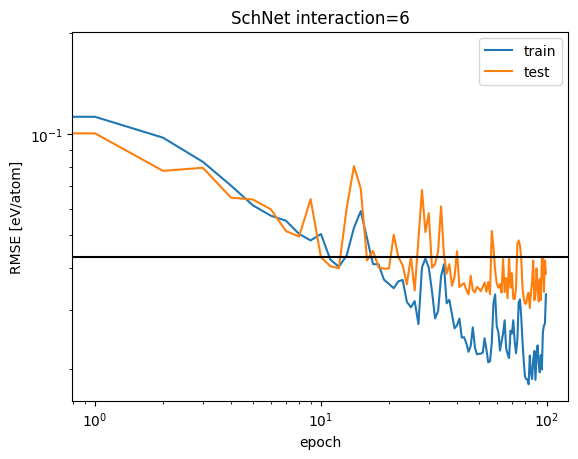

In [163]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("SchNet interaction=6")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

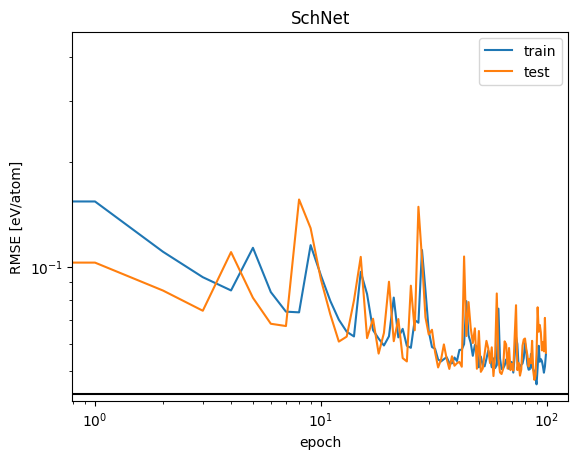

In [102]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("SchNet")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

## Train OnlyPairAggregate

In [250]:
model = OnlyPairAggregate(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1,
                          sigmas=[0.1, 0.3, 0.5],
                dtype=DTYPE, device=DEVICE)
model.to(device=DEVICE, dtype=DTYPE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in train_dataloader:
    y = batch.pop('scaled_dressed_energies_per_atom')
    train_loss = 0.
    for epoch_index in range(200):
        # Every data instance is an input + label pair
    
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # Make predictions for this batch
        y_pred = model.forward(**batch)
    
        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()
    
        # Adjust learning weights
        optimizer.step()
        train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    print("{0:0.5f}".format(train_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_output_layers.0.weight
_output_layers.0.bias
_output_layers.1.weight
_output_layers.1.bias
0.02681
0.02312


KeyboardInterrupt: 

In [268]:
model = OnlyPairAggregate(cutoff=CUTOFF, feature_size=128, layers_per_interaction=2,
                          sigmas=[0.1, 0.3, 0.5],
                dtype=DTYPE, device=DEVICE)
model.to(device=DEVICE, dtype=DTYPE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_output_layers.0.weight
_output_layers.0.bias
_output_layers.1.weight
_output_layers.1.bias
_output_layers.2.weight
_output_layers.2.bias
25.68613 13.36878
8.22832 3.53812
3.41835 1.32670
1.97662 1.85185
1.18766 0.68128
0.59078 0.57654
0.52382 0.47718
0.48135 0.47373
0.46751 0.46103
0.45692 0.44914
0.44456 0.44379
0.43874 0.43301
0.42814 0.42455
0.41821 0.41803
0.41008 0.41182
0.40334 0.40977
0.39414 0.39648
0.38481 0.40737
0.38542 0.40360
0.37203 0.36633
0.35825 0.37252
0.35779 0.38149
0.34407 0.35144
0.33578 0.34158
0.32957 0.35045
0.32543 0.31833
0.30996 0.31087
0.30197 0.30463
0.29584 0.29447
0.28712 0.28925
0.28282 0.28593
0.27505 0.27407
0.26728 0.26549
0.25816 0.26132
0.25329 0.25151
0.24698 0.24567
0.24190 0.23819
0.23310 0.23948
0.22910 0.22644
0.22146 0.22446
0.21583 0.21561
0.21206 0.21321
0.20906 0.21569
0.20234 0.20014
0.19548 0.19509
0.

In [275]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.09184 0.16389
0.11452 0.19326
0.17163 0.06688
0.08282 0.06695
0.07433 0.08170
0.07919 0.09707
0.07267 0.13576
0.15474 0.16959
0.27853 0.38659
0.34277 0.06490
0.09722 0.12438
0.14082 0.22895
0.42669 0.40982
0.61307 0.49722
0.63477 1.04911
0.91548 0.10951
0.21054 0.36483
0.42675 0.06701
0.15213 0.22419
0.18411 0.11324
0.10757 0.07859
0.10266 0.07313
0.07095 0.08157
0.09178 0.15920
0.16637 0.19561
0.17344 0.49401
0.45848 1.03400
1.18407 0.82211
0.86010 1.52096
0.96808 1.49668
1.12060 1.16003
1.03953 1.61888
1.26265 1.50023
1.06991 0.32808
0.47302 0.29025
0.17631 0.10454
0.11763 0.14328
0.09007 0.06887
0.06329 0.06345
0.06090 0.06855
0.05972 0.07503
0.06298 0.07078
0.06248 0.06245
0.08110 0.17464
0.12782 0.17659
0.12704 0.18371
0.14446 0.24214
0.16456 0.25022
0.15472 0.20905
0.17113 0.24997
0.19418 0.35238
0.24531 0.34869
0.27006 0.20965
0.18256 0.12475
0.10950 0.08901
0.07333 0.09633
0.07540 0.07988
0.06736 0.06311
0.06678 0.14130
0.13185 0.12299
0.09340 0.06711
0.06776 0.12819
0.08654 

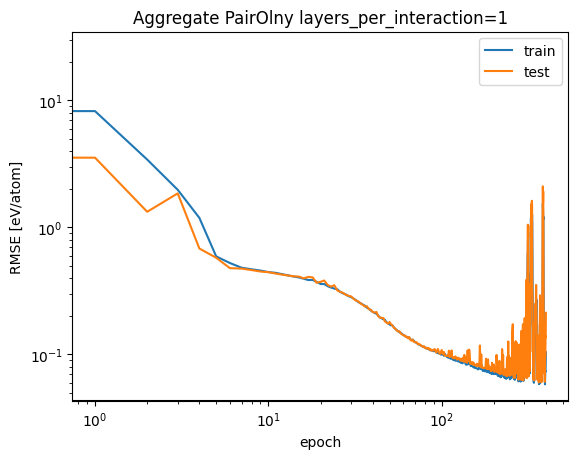

In [276]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Aggregate PairOlny layers_per_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig('sigmoid_training.pdf')
plt.show()
plt.close()

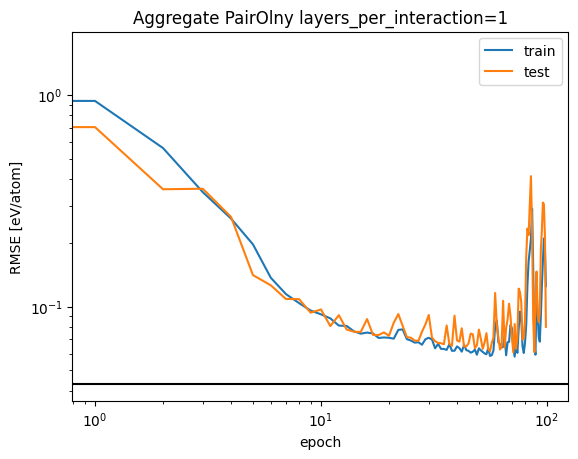

In [264]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Aggregate PairOlny layers_per_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

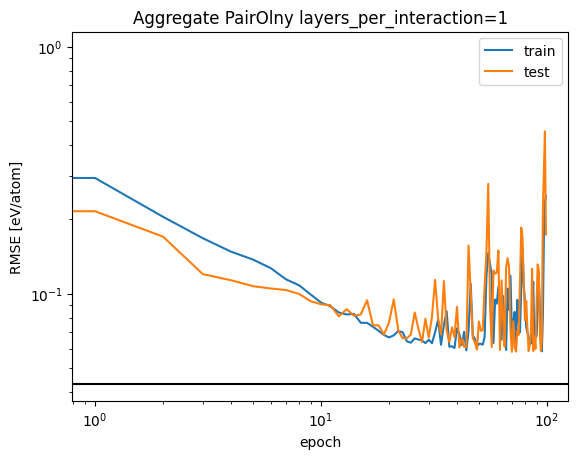

In [261]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Aggregate PairOlny layers_per_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [255]:

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.05858 0.06325
0.05878 0.06088
0.05736 0.06111
0.05769 0.06184
0.05790 0.07390
0.06447 0.06115
0.05764 0.06966
0.06168 0.07778
0.06518 0.08235
0.06738 0.07676
0.06355 0.06350
0.05840 0.08695
0.07360 0.09620
0.07416 0.07803
0.06497 0.06185
0.05838 0.06022
0.05685 0.06076
0.05775 0.06294
0.05727 0.06301
0.05994 0.07175
0.06239 0.09120
0.06833 0.09891
0.07720 0.13181
0.09561 0.15477
0.10131 0.16524
0.11730 0.22831
0.17131 0.35206
0.24429 0.46473
0.33351 0.65894
0.43067 0.35576
0.23525 0.15545
0.14551 0.16055
0.11178 0.06606
0.06688 0.09036
0.06877 0.06002
0.05810 0.06090
0.05705 0.06449
0.06127 0.06545
0.05986 0.05951
0.05707 0.06802
0.06216 0.06002
0.05634 0.05950
0.05610 0.06118
0.05862 0.08064
0.06593 0.06591
0.05980 0.06065
0.05704 0.06301
0.05688 0.05943
0.05657 0.06742
0.05991 0.06681
0.06058 0.05984
0.05588 0.06186
0.05834 0.07891
0.06604 0.08925
0.07224 0.10080
0.07692 0.09470
0.07677 0.08455
0.06823 0.06447
0.06144 0.07507
0.06064 0.06641
0.05799 0.06048
0.05843 0.07194
0.06076 

KeyboardInterrupt: 

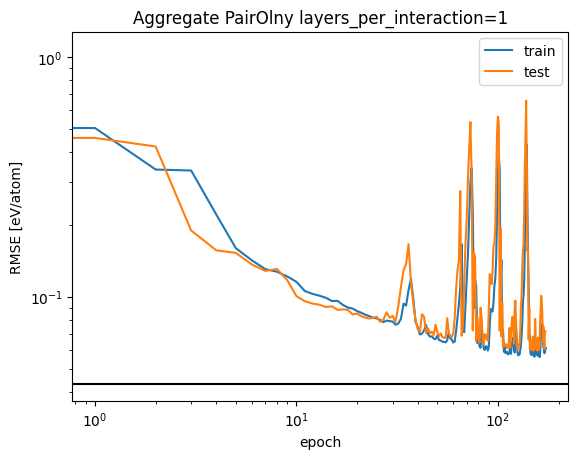

In [256]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Aggregate PairOlny layers_per_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

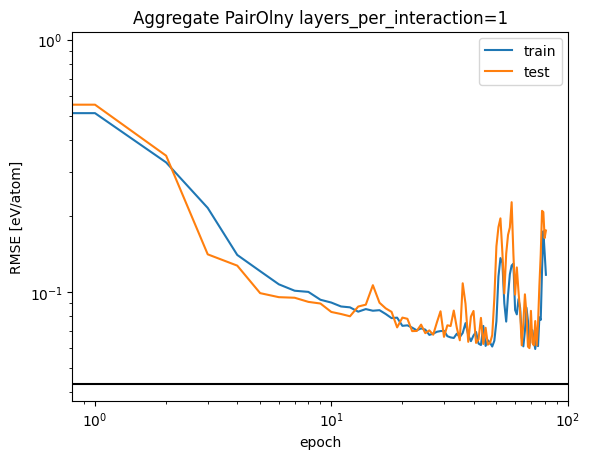

In [247]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Aggregate PairOlny layers_per_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

## Training - Spliney

### Train one batch

In [291]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in train_dataloader:
    y = batch.pop('scaled_dressed_energies_per_atom')
    train_loss = 0.
    for epoch_index in range(200):
        # Every data instance is an input + label pair
    
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # Make predictions for this batch
        y_pred = model.forward(**batch)
    
        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()
    
        # Adjust learning weights
        optimizer.step()
        train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    print("{0:0.5f}".format(train_loss))


TypeError: Spliney.__init__() got an unexpected keyword argument 'interaction'

### Train whole dataset

In [316]:
model = Spliney(cutoff=CUTOFF/2, feature_size=128, layers_per_interaction=1, self_interaction=1, neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader_cutoffd2:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader_cutoffd2:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_layers.3.0.weight
_layers.3.0.bias
_layers.4.0.weight
_layers.4.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_self_interaction_layers.0.3.0.weight
_self_interaction_layers.0.3.0.bias
_self_interaction_layers.0.4.0.weight
_self_interaction_layers.0.4.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.0.2.0.weight
_neighbor_interaction_layers.0.2.0.bias
_neighbor_interaction_layers.0.3.0.weight
_neighbor_interaction_layers.0.3.0.bias
_neighbor_interaction_layers.0.4.0.weight
_neighbor_interaction_layers.0.4.0.bias
_output_la

In [318]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, self_interaction=4, neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_self_interaction_layers.3.0.0.weight
_self_interaction_layers.3.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_self_interaction_linear_layers.1.weight
_self_interaction_linear_layers.1.bias
_self_interaction_linear_layers.2.weight
_self_interaction_linear_layers.2.bias
_self_interaction_linear_layers.3.weight
_self_interaction_linear_layers.3.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.31825 0.21121
0.21535 0.17661
3.57095 2.31050
63.99843 47.36240
136.73424 10.12362
18.27495 7.96708
6.0114

In [323]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.07332 0.08132
0.07291 0.08100
0.07275 0.08099
0.07257 0.08070
0.07244 0.08062
0.07234 0.08060
0.07214 0.08029
0.07203 0.08020
0.07202 0.08023
0.07185 0.07994
0.07163 0.07991
0.07146 0.07971
0.07138 0.07958
0.07129 0.07948
0.07104 0.07932
0.07087 0.07928
0.07079 0.07913
0.07063 0.07892
0.07048 0.07888
0.07038 0.07865
0.07027 0.07863
0.07017 0.07856
0.06994 0.07829
0.06990 0.07815
0.06967 0.07826
0.06955 0.07791
0.06943 0.07780
0.06932 0.07763
0.06914 0.07756
0.06902 0.07746
0.06893 0.07732
0.06883 0.07715
0.06861 0.07712
0.06852 0.07701
0.06838 0.07682
0.06823 0.07666
0.06808 0.07663
0.06810 0.07639
0.06794 0.07641
0.06785 0.07622
0.06757 0.07612
0.06749 0.07590
0.06736 0.07583
0.06734 0.07565
0.06719 0.07563
0.06706 0.07550
0.06687 0.07539
0.06686 0.07520
0.06665 0.07515
0.06655 0.07489
0.06639 0.07488
0.06628 0.07475
0.06611 0.07454
0.06605 0.07452
0.06593 0.07440
0.06580 0.07425
0.06565 0.07405
0.06552 0.07398
0.06543 0.07385
0.06532 0.07374
0.06519 0.07364
0.06508 0.07348
0.06494 

In [324]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.06108 0.06888
0.06107 0.06882
0.06091 0.06853
0.06083 0.06856
0.06085 0.06818
0.06070 0.06819
0.06052 0.06801
0.06049 0.06798
0.06036 0.06785
0.06031 0.06760
0.06023 0.06756
0.06021 0.06745
0.06008 0.06740
0.06003 0.06709
0.05992 0.06732
0.05976 0.06681
0.05967 0.06691
0.05959 0.06665
0.05961 0.06658
0.05944 0.06688
0.05947 0.06626
0.05951 0.06611
0.05918 0.06618
0.05919 0.06592
0.05918 0.06609
0.05911 0.06582
0.05886 0.06548
0.05880 0.06559
0.05880 0.06531
0.05865 0.06522
0.05869 0.06513
0.05847 0.06508
0.05840 0.06488
0.05846 0.06483
0.05842 0.06499
0.05826 0.06439
0.05809 0.06445
0.05805 0.06423
0.05819 0.06458
0.05825 0.06393
0.05800 0.06389
0.05782 0.06355
0.05765 0.06372
0.05754 0.06347
0.05757 0.06347
0.05748 0.06333
0.05724 0.06330
0.05734 0.06332
0.05759 0.06343
0.05726 0.06262
0.05722 0.06253
0.05706 0.06292
0.05691 0.06230
0.05680 0.06235
0.05677 0.06244
0.05667 0.06221
0.05676 0.06213
0.05664 0.06199
0.05648 0.06162
0.05643 0.06171
0.05635 0.06169
0.05628 0.06138
0.05609 

In [325]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.05319 0.06125
0.05287 0.06162
0.05271 0.06120
0.05273 0.06112
0.05256 0.06155
0.05257 0.06156
0.05252 0.06137
0.05248 0.06172
0.05252 0.06209
0.05260 0.06239
0.05223 0.06160
0.05234 0.06328
0.05294 0.06216
0.05230 0.06299
0.05190 0.06153
0.05205 0.06196
0.05180 0.06165
0.05172 0.06141
0.05189 0.06126
0.05172 0.06178
0.05144 0.06127
0.05144 0.06157
0.05146 0.06134
0.05127 0.06125
0.05158 0.06117
0.05118 0.06094
0.05112 0.06115
0.05126 0.06131
0.05106 0.06095
0.05129 0.06126
0.05116 0.06117
0.05088 0.06114
0.05071 0.06099
0.05068 0.06100
0.05085 0.06115
0.05055 0.06000
0.05059 0.06029
0.05047 0.06073
0.05060 0.06042
0.05018 0.05963
0.05027 0.05967
0.05026 0.06014
0.05026 0.06023
0.04984 0.05949
0.05002 0.05966
0.05007 0.05924
0.04972 0.05949
0.04972 0.05957
0.04973 0.05981
0.04946 0.05941
0.04941 0.05874
0.04952 0.05922
0.04946 0.05955
0.04978 0.05883
0.04921 0.05949
0.04935 0.05821
0.04927 0.05856
0.04911 0.05927
0.04892 0.05818
0.04906 0.05795
0.04891 0.05808
0.04920 0.05861
0.04853 

In [327]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.04563 0.05336
0.04574 0.05374
0.04596 0.05321
0.04549 0.05336
0.04542 0.05288
0.04546 0.05384
0.04554 0.05397
0.04526 0.05340
0.04526 0.05259
0.04561 0.05291
0.04532 0.05210
0.04500 0.05226
0.04551 0.05260
0.04548 0.05228
0.04475 0.05165
0.04534 0.05197
0.04509 0.05292
0.04524 0.05174
0.04475 0.05148
0.04511 0.05184
0.04464 0.05144
0.04438 0.05197
0.04434 0.05101
0.04437 0.05129
0.04427 0.05062
0.04441 0.05084
0.04411 0.05055
0.04411 0.05043
0.04386 0.05056
0.04412 0.05088
0.04396 0.05158
0.04416 0.05089
0.04397 0.05008
0.04342 0.05006
0.04359 0.04965
0.04359 0.05112
0.04414 0.04918
0.04373 0.05048
0.04373 0.04931
0.04312 0.04942
0.04369 0.04963
0.04350 0.04888
0.04288 0.04865
0.04282 0.04906
0.04318 0.04954
0.04311 0.04976
0.04312 0.04944
0.04257 0.04823
0.04254 0.04790
0.04370 0.05239
0.04350 0.04872
0.04258 0.04768
0.04274 0.04794
0.04268 0.04831
0.04236 0.04796
0.04310 0.04744
0.04262 0.04895
0.04242 0.04759
0.04217 0.04743
0.04228 0.04882
0.04290 0.04888
0.04339 0.04752
0.04233 

In [328]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.04071 0.04411
0.04233 0.04540
0.04083 0.04474
0.04096 0.04708
0.04100 0.04534
0.04203 0.04707
0.04180 0.04547
0.04168 0.04545
0.04192 0.04420
0.04015 0.04538
0.04108 0.04501
0.04081 0.04414
0.03994 0.04388
0.04095 0.04476
0.04135 0.04627
0.04010 0.04438
0.03975 0.04434
0.03975 0.04421
0.04120 0.04428
0.04022 0.04560
0.04091 0.04982
0.04190 0.04386
0.04052 0.04803
0.04146 0.04579
0.04283 0.04400
0.04194 0.04952
0.04260 0.04500
0.04097 0.04498
0.03974 0.04535
0.04028 0.04354
0.04060 0.04357
0.03911 0.04538
0.03967 0.04338
0.04012 0.04672
0.04146 0.04506
0.04045 0.04385
0.03974 0.04529
0.04014 0.04369
0.04063 0.04365
0.03912 0.04558
0.04040 0.04578
0.03935 0.04342
0.03990 0.04423
0.03926 0.04671
0.04042 0.04642
0.03969 0.04546
0.03965 0.04448
0.03945 0.04498
0.03914 0.04324
0.03925 0.04315
0.03917 0.04366
0.03975 0.04461
0.04185 0.05028
0.04455 0.06075
0.04748 0.04759
0.04428 0.04945
0.04069 0.04546
0.03935 0.04521
0.04015 0.05023
0.04167 0.04514
0.04007 0.04822
0.04208 0.04691
0.04532 

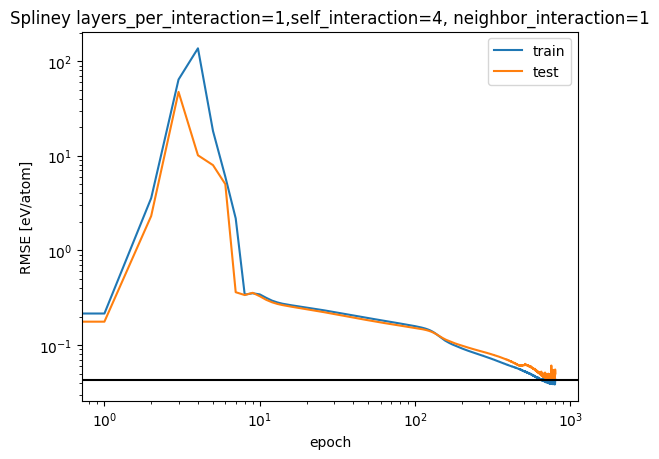

In [329]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=1,self_interaction=4, neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [104]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1,
                self_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
0.19798 0.17539
0.16457 0.13204
0.13413 0.10960
0.12113 0.09924
0.11357 0.09722
0.10941 0.09420
0.10484 0.09301
0.10202 0.08992
0.09722 0.08868
0.09315 0.09451
0.08958 0.08124
0.08206 0.07761
0.07699 0.07494
0.07294 0.07125
0.06875 0.06906
0.06519 0.07119
0.06553 0.06328
0.05984 0.06189
0.06325 0.06002
0.05713 0.05899
0.05547 0.05787
0.05710 0.05987
0.05573 0.06354
0.05497 0.06325
0.05501 0.05795
0.05216 0.05494
0.05107 0.05379
0.04995 0.05690
0.05174 0.05422
0.05187 0.05350
0.04927 0.05941
0.05224 0.05298
0.04797 0.05267
0.04835 0.06083
0.05546 0.05920
0.05000 0.05174
0.04781 0.05893
0.04816 0.05460
0.04781 0.06167
0.04953 0.05603
0.04901 0.05988
0.05187 0.05655
0.04815 0.05543
0.04794 0.05205
0.04696 0.05151
0.04636 0.05130
0.04

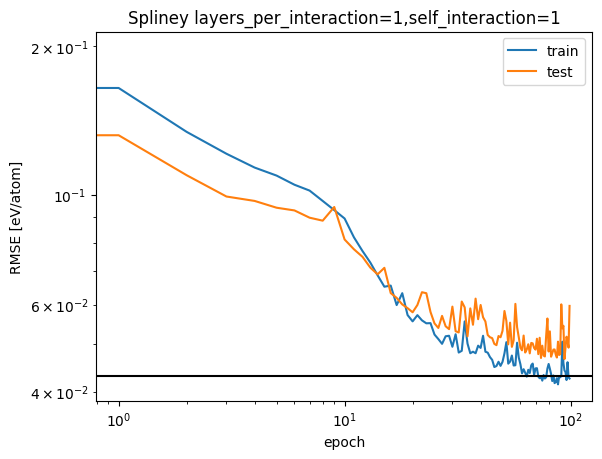

In [105]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=1,self_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [180]:
#model = SplineyAggregate(cutoff=CUTOFF, feature_size=128,
#                layers_per_interaction=1,self_interaction=1, neighbor_interaction=1,
#                dtype=DTYPE, device=DEVICE)
model = Spliney(cutoff=CUTOFF, layers_per_interaction=3, self_interaction=3, dtype=DTYPE, device=DEVICE)
#model.to(dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

n_epoch = 200
train_losses = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.1.1.0.weight
_self_interaction_layers.1.1.0.bias
_self_interaction_layers.1.2.0.weight
_self_interaction_layers.1.2.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_self_interaction_layers.2.1.0.weight
_self_interaction_layers.2.1.0.bias
_self_interaction_layers.2.2.0.weight
_self_interaction_layers.2.2.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_self_interaction_linear_layers.1.weight
_self_interaction_linear_layers.1.b

KeyboardInterrupt: 

In [181]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.08521 0.06428
0.05208 0.05225
0.04369 0.04837
0.04051 0.04466
0.03943 0.04423
0.03981 0.04923
0.04279 0.04900
0.03989 0.04425
0.03920 0.04680
0.04072 0.04513
0.04158 0.04708
0.04041 0.05060
0.04200 0.05873
0.04369 0.04382
0.04148 0.04770
0.04128 0.04801
0.04377 0.06374
0.04985 0.04891
0.04521 0.04718
0.04264 0.05081
0.04227 0.04926
0.04345 0.04389
0.03990 0.06174
0.04394 0.05034
0.04213 0.04392
0.04181 0.05027
0.04144 0.04697
0.04152 0.04642
0.03979 0.05135
0.04099 0.04768
0.04105 0.05988
0.04575 0.04535
0.04001 0.04498
0.03915 0.04456
0.03870 0.04342
0.04021 0.05578
0.04253 0.04444
0.03887 0.04503
0.04361 0.05329
0.04155 0.04497
0.04150 0.04749
0.04378 0.05110
0.04346 0.04603
0.04143 0.04716
0.03930 0.04898


KeyboardInterrupt: 

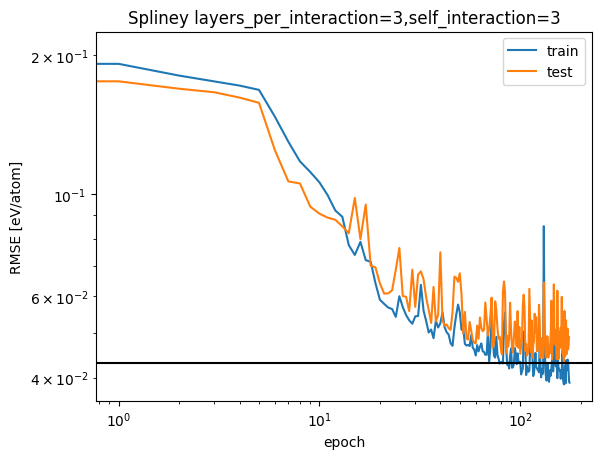

In [182]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=3,self_interaction=3")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [112]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=1,self_interaction=1, neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 200
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.20603 0.18251
0.18918 0.16024
0.16471 0.14038
0.14064 0.11394
0.12441 0.10357
0.11491 0.09613
0.10742 0.09092
0.10001 0.08677
0.09154 0.08247
0.08531 0.09025
0.08251 0.08377
0.07661 0.08176
0.07315 0.07432
0.06885 0.06855
0.06650 0.06821
0.06451 0.06568
0.06220 0.06317
0.06217 0.06245
0.05962 0.06049
0.05873 0.06080
0.05969 0.07148
0.05961 0.05956
0.05606 0.06017
0.05470 0.05644
0.05412 0.05626
0.05320 0.05547
0.05272 0.05500
0.05315 0.05418
0.05322 0.05505
0.05252 0.05466
0.05050 0.05298
0.04907 0.05235
0.04933 0.05381
0.04957 0.05512
0.05003 0.05035
0.04748 0.

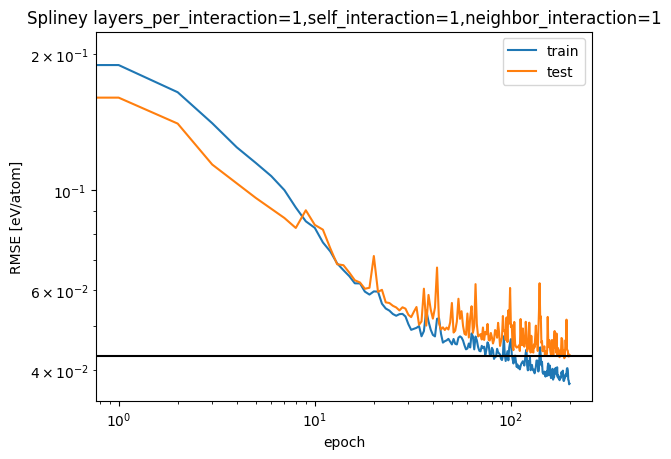

In [113]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=1,self_interaction=1,neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [183]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=3, self_interaction=1, neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 200
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.0.2.0.weight
_neighbor_interaction_layers.0.2.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.20581 0.17967
0.17648 0.14475
0.13979 0.11698
0.12272 0.10158
0.11346 0.10281
0.10200 0.09554
0.09333 0.08198
0.08273 0.08830
0.07778 0.08094
0.07118 0.07817
0.07160 0.06863
0.06339 0.

KeyboardInterrupt: 

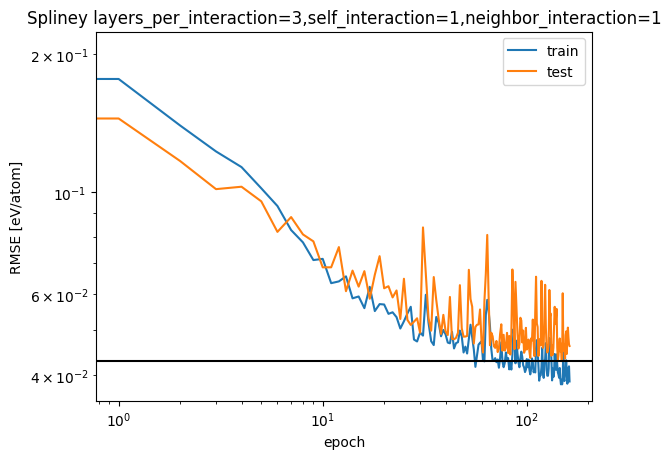

In [184]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=3,self_interaction=1,neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [106]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=2, self_interaction=0,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_output_layer.weight
_output_layer.bias
0.29832 0.21911
0.16594 0.11414
0.12787 0.10536
0.11598 0.10452
0.11039 0.09576
0.10615 0.09560
0.10409 0.09649
0.09908 0.09132
0.09674 0.08655
0.09309 0.09259
0.09258 0.09017
0.09109 0.08624
0.08868 0.08465
0.08153 0.08336
0.07965 0.07629
0.07775 0.07769
0.07443 0.07743
0.07428 0.08451
0.07746 0.08621
0.08024 0.10569
0.08449 0.07627
0.07505 0.06949
0.06809 0.07481
0.06971 0.07352
0.06776 0.08550
0.06944 0.11694
0.09260 0.14429
0.08865 0.12701
0.09706 0.13064
0.09597 0.06897
0.06761 0.06752
0.06490 0.06602
0.06409 0.06642
0.06382 0.07251
0.06439 0.06638
0.06374 0.07185
0.06257 0.06518
0.06433 0.06460
0.06409 0.06338
0.05990 0.06374
0.06080 0.06724
0.06051 0.06348
0.06214 0.06348
0.06156 0.06736
0.06147 0.06333
0.06121 0.08745
0.06972 0.06189
0.06207 0.06791
0.07195 0.10816
0.08660 0.08726
0.06291 0.07650
0.06261 0.06896
0.06894 0.06211
0.06209 0.

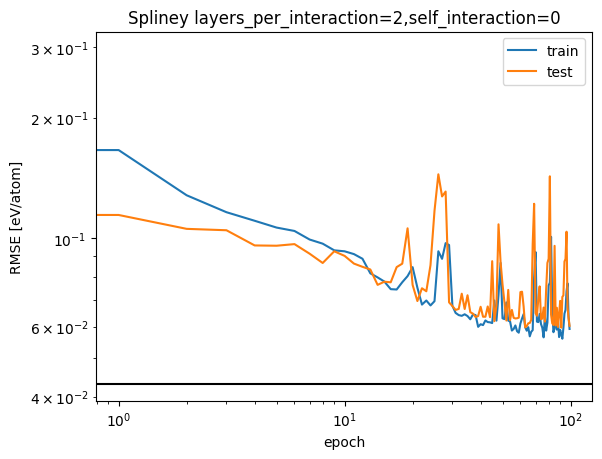

In [107]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=2,self_interaction=0")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

### PointEdge training

In [187]:
model = PointEdge(cutoff=CUTOFF, feature_size=128, layers_per_interaction=2, interaction=3,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layer_linear.weight
_layer_linear.bias
_center_layers.0.0.weight
_center_layers.0.0.bias
_center_layers.1.0.weight
_center_layers.1.0.bias
_center_layer_linear.weight
_center_layer_linear.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.1.1.0.weight
_self_interaction_layers.1.1.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_self_interaction_layers.2.1.0.weight
_self_interaction_layers.2.1.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.1.0.0.weight
_neighbor_interaction_layers.1.0.0.bias
_neighbor_inte

KeyboardInterrupt: 

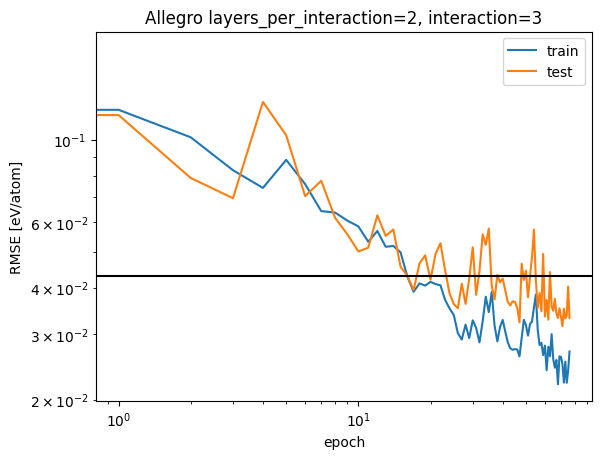

In [188]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("PointEdge layers_per_interaction=2, interaction=3")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [194]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.09712 0.18346
0.08765 0.18621
0.09335 0.21383
0.08484 0.20788
0.08707 0.19322
0.08231 0.18192
0.07974 0.19053
0.08681 0.17825
0.08229 0.19031
0.08298 0.18497
0.08140 0.17632
0.08173 0.18719
0.08430 0.20017
0.09085 0.19817
0.08591 0.18176
0.09898 0.19053
0.08619 0.18196
0.07902 0.18180
0.08668 0.18882
0.07936 0.17859
0.09240 0.19041
0.09969 0.18686
0.09597 0.18408
0.08305 0.17898
0.08345 0.18095
0.08317 0.18267
0.08196 0.17951
0.07853 0.17778
0.07437 0.18305
0.07862 0.18589
0.07817 0.18643
0.07779 0.19269
0.07928 0.17355
0.08236 0.18251
0.08478 0.17868
0.10269 0.21488
0.11627 0.18267
0.09037 0.16845
0.08620 0.17143
0.08675 0.18703
0.09014 0.17169
0.08241 0.18021
0.07784 0.17470
0.08211 0.18566
0.08322 0.17900
0.08385 0.19756
0.09816 0.18644
0.08243 0.17690
0.07963 0.17365
0.08253 0.18545
0.08615 0.18932
0.09535 0.18600
0.07875 0.18889
0.08235 0.17457
0.08091 0.17591
0.08143 0.18809
0.09242 0.18652
0.09087 0.17826
0.08284 0.17877
0.08273 0.17950
0.08080 0.19859
0.09272 0.17248
0.13784 

In [634]:
per_struc_loss = []
nb_atoms = []
with torch.no_grad():
    for batch in train_dataloader:
        # Gather data and report
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        per_struc_loss.extend(((y_pred - y)**2).detach().cpu().numpy().tolist())
        nb_atoms.extend((batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]).detach().cpu().numpy().tolist())
        nb_atoms.append(len(batch['positions']) - batch['structure_offsets'][-1].item())
        if any((y_pred - y)**2 > 1.0):
            idx = torch.argmax((y_pred - y)**2)
            print((torch.max((y_pred - y)**2)))
            print(batch['positions'][batch['structure_offsets'][idx]:batch['structure_offsets'][idx+1]])

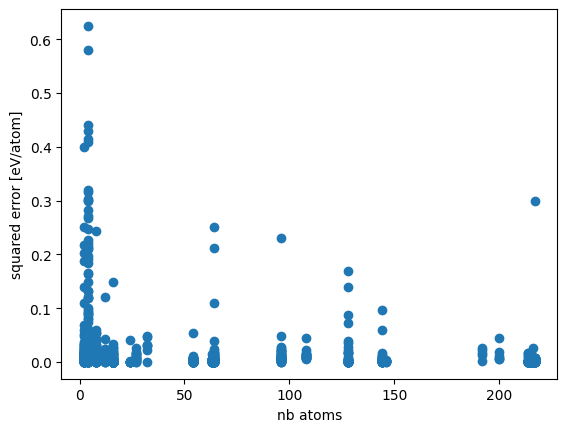

In [635]:
plt.scatter(nb_atoms, per_struc_loss)
plt.xlabel('nb atoms')
plt.ylabel('squared error [eV/atom]')
plt.show()
plt.close()

In [636]:
per_struc_loss = []
nb_atoms = []
with torch.no_grad():
    for batch in test_dataloader:
        # Gather data and report
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        per_struc_loss.extend(((y_pred - y)**2).detach().cpu().numpy().tolist())
        nb_atoms.extend((batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]).detach().cpu().numpy().tolist())
        nb_atoms.append(len(batch['positions']) - batch['structure_offsets'][-1].item())

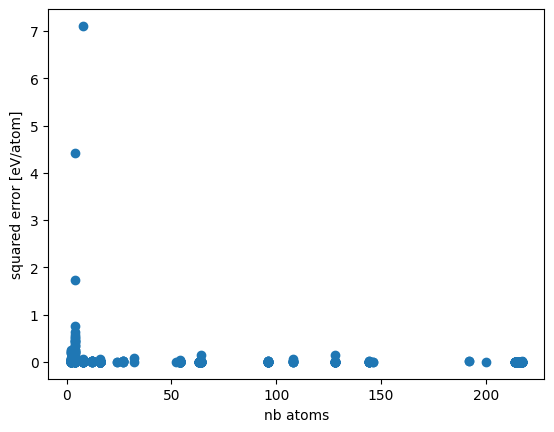

In [637]:
plt.scatter(nb_atoms, per_struc_loss)
plt.xlabel('nb atoms')
plt.ylabel('squared error [eV/atom]')
plt.show()
plt.close()

In [533]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=3, self_interaction=0, neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_output_layer.weight
_output_layer.bias
1.98509 1.21100
0.84699 0.48362
0.53117 0.23477
0.25240 0.17849
0.19243 0.13254
0.15771 0.11039
0.14727 0.10212
0.14354 0.09845
0.14161 0.09983
0.14121 0.09884
0.14108 0.09584
0.13948 0.09445
0.13940 0.09552
0.13891 0.09229
0.13849 0.09209
0.13718 0.09124
0.13649 0.08956
0.13597 0.08881
0.13512 0.08853
0.13527 0.08833
0.13470 0.08602
0.13544 0.08498
0.13346 0.09151
0.13487 0.08727
0.13859 0.09651
0.13451 0.08359
0.13302 0.08377
0.13204 0.08283
0.13221 0.08442
0.13314 0.08062
0.13165 0.08397
0.13002 0.07926


KeyboardInterrupt: 

In [ ]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


In [452]:
train_losses_lpr1_si0 = train_losses
test_losses_lpr1_si0 = test_losses

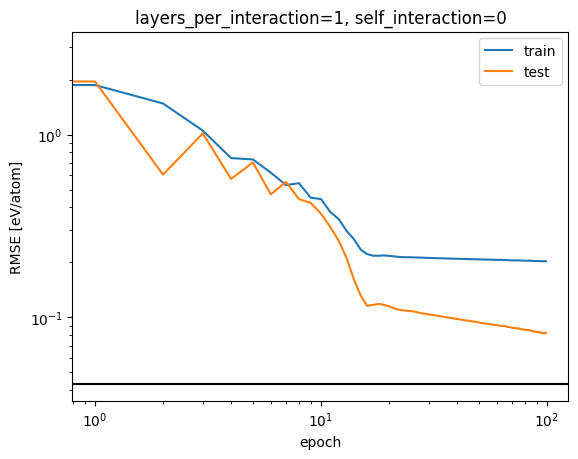

In [456]:
plt.loglog(train_losses_lpr1_si0, label='train')
plt.loglog(test_losses_lpr1_si0, label='test')
plt.title("layers_per_interaction=1, self_interaction=0")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr1_si0.png")
plt.show()
plt.close()

In [491]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=1, dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):   train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.66471 0.64743
0.65428 0.63768
0.64474 0.62894
0.63807 0.62207
0.63406 0.61492
0.62588 0.60413
0.61490 0.58761
0.59662 0.56428
0.57522 0.53220
0.54574 0.49466
0.51143 0.45258
0.47639 0.41624
0.43833 0.37005
0.39914 0.33246
0.37222 0.29304
0.33611 0.25262
0.30366 0.22757
0.28166 0.19925
0.26839 0.16408
0.24801 0.16076
0.24152 0.13372
0.23300 0.13871
0.22636 0.11884
0.22200 0.12080
0.22000 0.11184
0.21678 0.10911
0.21494 0.10593
0.21351 0.10246
0.21213 0.10000
0.21144 0.09776
0.21032 0.09577
0.20943 0.09422
0.20902 0.09222
0.20799 0.09048
0.20734 0.08872
0.20674 0.08811
0.20606 0.09262
0.20726 0.08509
0.20603 0.08904
0.20608 0.08356
0.20569 0.08276
0.20438 0.08161
0.20360 0.07955
0.20307 0.07915
0.20306 0.07779
0.20311 0.08445
0.20303 0.07603
0.20306 0.07693
0.20195 0.07557
0.20109 0.07390
0.20074 0.07614
0.20078 0.07224
0.20010 0.

In [ ]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=1, dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


In [492]:
train_losses_lpr0_si0_ni1 = train_losses
test_losses_lpr0_si0_ni1 = test_losses

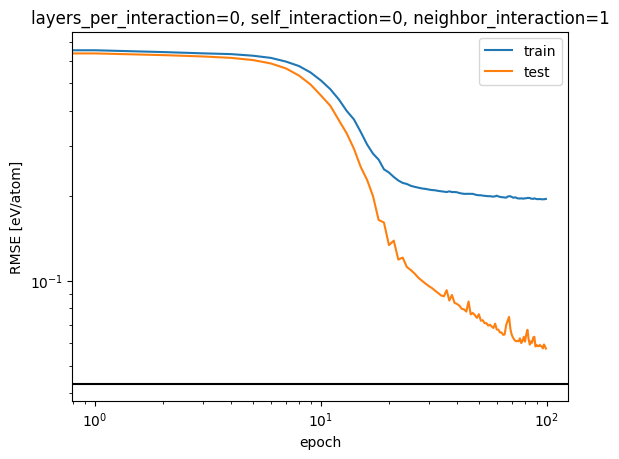

In [493]:
plt.loglog(train_losses_lpr0_si0_ni1, label='train')
plt.loglog(test_losses_lpr0_si0_ni1, label='test')
plt.title("layers_per_interaction=0, self_interaction=0, neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr0_si0_ni1.png")
plt.show()
plt.close()

In [500]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=5, self_interaction=2, neighbor_interaction=2, dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.1.1.0.weight
_self_interaction_layers.1.1.0.bias
_self_interaction_layers.1.2.0.weight
_self_interaction_layers.1.2.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.0.2.0.weight
_neighbor_interaction_layers.0.2.0.bias
_neighbor_interaction_layers.1.0.0.weight
_neighbor_interaction_layers.1.0.0.bias
_neighbor_interaction_layers.1.1.0.weight
_neighbor_interaction_layers.1.1.0.bias
_neighbo

In [461]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=1, dtype=DTYPE, device=DEVICE)

In [462]:
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias


In [463]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [464]:
n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.66759 0.65383
0.65617 0.64242
0.64852 0.63054
0.63842 0.61834
0.62816 0.60710
0.61813 0.59231
0.60371 0.57295
0.58292 0.54713
0.55878 0.51143
0.52936 0.46921
0.48615 0.42885
0.44947 0.38748
0.41425 0.34859
0.37763 0.30889
0.34529 0.27624
0.31421 0.23201
0.28724 0.19918
0.26663 0.17106
0.25181 0.14852
0.24394 0.13514
0.23099 0.12963
0.22542 0.11630
0.22081 0.11061
0.21771 0.11323
0.21810 0.10627
0.21603 0.10200
0.21377 0.09863
0.21187 0.09578
0.21060 0.09359
0.21023 0.09625
0.21018 0.08899
0.20830 0.08759
0.20766 0.08580
0.20693 0.08339
0.20652 0.08382
0.20566 0.08126
0.20531 0.07946
0.20483 0.07889
0.20430 0.07921
0.20415 0.07748
0.20399 0.07886
0.20349 0.07654
0.20268 0.07360
0.20221 0.07342
0.20171 0.07166
0.20147 0.07310
0.20101 0.07351
0.20131 0.07402
0.20139 0.07560
0.20054 0.06967
0.20011 0.06676
0.20060 0.06663
0.20206 0.06601
0.20188 0.06498
0.19978 0.06472
0.19879 0.06469
0.19792 0.06344
0.19807 0.06270
0.19751 0.06237
0.19737 0.06382
0.19704 0.06138
0.19683 0.06088
0.19657 

In [467]:
train_losses_lpr0_si1 = train_losses
test_losses_lpr0_si1 = test_losses

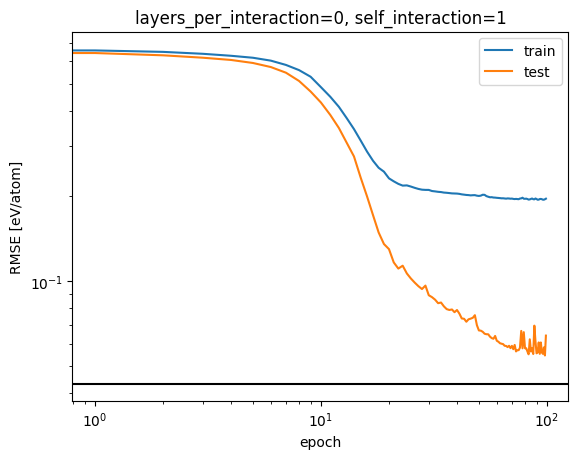

In [468]:
plt.loglog(train_losses_lpr0_si1, label='train')
plt.loglog(test_losses_lpr0_si1, label='test')
plt.title("layers_per_interaction=0, self_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr0_si1.png")
plt.show()
plt.close()

In [435]:
train_losses_lpr1_si1 = train_losses
test_losses_lpr1_si1 = test_losses


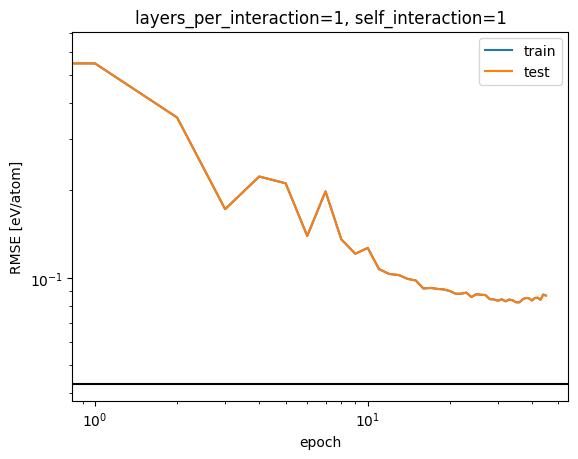

In [450]:
plt.loglog(train_losses_lpr1_si1, label='train')
plt.loglog(test_losses_lpr1_si1, label='test')
plt.title("layers_per_interaction=1, self_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr1_si1.png")
plt.show()
plt.close()

## Training - SchNet

In [193]:
from schnetpack as spk

#pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
schnet = spk.representation.SchNet(
    n_atom_basis=128,
    n_interactions=1,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)


SyntaxError: invalid syntax (2528222753.py, line 1)

In [ ]:
schnet

## Training - RadialSpectrum

In [114]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=5, self_interaction=0, neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 200
train_losses = []
test_losses = []
train_losses_eV = []
test_losses_eV = []
nb_atoms = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()

    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_layers.3.0.weight
_layers.3.0.bias
_layers.4.0.weight
_layers.4.0.bias
_output_layer.weight
_output_layer.bias
0.24582 0.20150
0.18153 0.15061
0.11442 0.07764
0.07834 0.07449
0.06993 0.05823
0.05536 0.05285
0.05289 0.04989
0.04672 0.05150
0.04565 0.05644
0.05059 0.06090
0.04386 0.04905
0.04151 0.04791
0.04044 0.04369
0.03692 0.04909
0.04313 0.05122
0.03841 0.04231
0.03487 0.04193
0.03345 0.04022
0.03280 0.04199
0.03157 0.03796
0.03036 0.05746
0.03676 0.03913
0.03220 0.04637
0.03274 0.04256
0.03355 0.04567
0.03679 0.04801
0.03444 0.03818
0.03051 0.03565
0.02901 0.03544
0.02544 0.03656
0.02529 0.03702
0.02585 0.05134
0.03385 0.04160
0.02669 0.03841
0.02707 0.03673
0.02764 0.04257
0.02892 0.03783
0.03268 0.04197
0.03099 0.03503
0.02848 0.03660
0.02463 0.03212
0.02380 0.04345
0.02661 0.03552
0.02372 0.03272
0.02298 0.03584
0.02612 0.04189
0.02672 0.0371

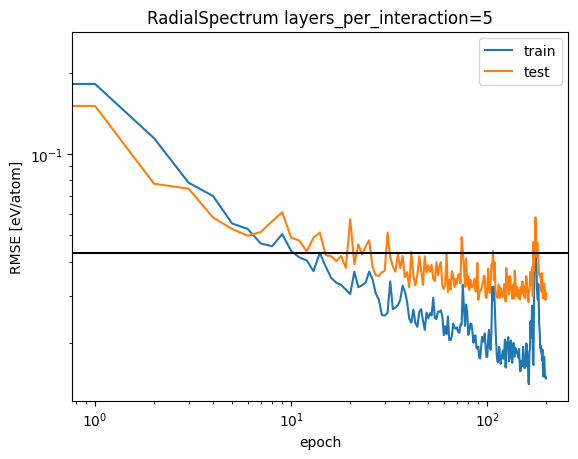

In [115]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("RadialSpectrum layers_per_interaction=5")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [127]:
ys = []
with torch.no_grad():
    for batch in train_dataloader:
        # Gather data and report
        ys.extend(batch.pop('scaled_dressed_energies_per_atom').cpu().numpy().tolist())

In [129]:
print(train_losses[-1].item()/np.std(ys))

0.0709988529611064


In [125]:
loss_eV = []
with torch.no_grad():
    for batch in train_dataloader:
        # Gather data and report
        nb_atoms = torch.zeros(len(batch['structure_offsets']))
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        nb_atoms[:-1] = batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]
        nb_atoms[-1] = len(batch['positions']) - batch['structure_offsets'][-1].item()
        loss_eV.extend(torch.sqrt(((y_pred.cpu() - y.cpu())*nb_atoms)**2/BATCH_SIZE).detach().cpu().numpy().tolist())


In [126]:
print(np.sqrt(np.mean(loss_eV)))

0.30310307397776465


In [130]:
loss_eV = []
with torch.no_grad():
    for batch in test_dataloader:
        # Gather data and report
        nb_atoms = torch.zeros(len(batch['structure_offsets']))
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        nb_atoms[:-1] = batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]
        nb_atoms[-1] = len(batch['positions']) - batch['structure_offsets'][-1].item()
        loss_eV.extend(torch.sqrt(((y_pred.cpu() - y.cpu())*nb_atoms)**2/BATCH_SIZE).detach().cpu().numpy().tolist())
print(np.sqrt(np.mean(loss_eV)))

0.349809501152386


In [ ]:
loss_eV = []
with torch.no_grad():
    for batch in test_dataloader:
        # Gather data and report
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        nb_atoms = batch.pop('nb_atoms')
        train_losses_eV = torch.sum(((y_pred.detach() - y.detach())*nb_atoms)**2)
        
print(np.sqrt(np.mean(loss_eV)))

In [120]:
torch.zeros(BATCH_SIZE)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [406]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=0, dtype=DTYPE, device=DEVICE)

In [407]:
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias


In [408]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [409]:
n_epoch = 50
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()
        train_loss += loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.76099 0.61322
0.60491 0.55382
0.58083 0.53394
0.54297 0.49386
0.50497 0.46114
0.47654 0.42877
0.44832 0.39608
0.42712 0.37171
0.40510 0.34911
0.38588 0.32604
0.36587 0.30730
0.34638 0.28916
0.33194 0.27056
0.31691 0.25265
0.30185 0.23677
0.29012 0.22212
0.27799 0.20785
0.26754 0.19451
0.25754 0.18260
0.24872 0.17179
0.24111 0.16176
0.23302 0.15268
0.22728 0.14385
0.22132 0.13673
0.21704 0.12962
0.21238 0.12398
0.20880 0.11884
0.20520 0.11469
0.20273 0.11066
0.20043 0.10729
0.19870 0.10414
0.19678 0.10153
0.19509 0.09956
0.19388 0.09775
0.19279 0.09603
0.19176 0.09467
0.19100 0.09321
0.19026 0.09233
0.18959 0.09145
0.18889 0.09062
0.18824 0.08985
0.18784 0.08914
0.18737 0.08840
0.18693 0.08774
0.18660 0.08705
0.18624 0.08644
0.18605 0.08585
0.18562 0.08545
0.18515 0.08500
0.18496 0.08443


In [244]:
debug_dataset = InMemoryDataset(frames[::10],
                          [TransformerNeighborList(cutoff=CUTOFF, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=torch.float64)])

In [245]:
debug_dataloader = torch.utils.data.DataLoader(debug_dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)

In [300]:
big_dataloader = torch.utils.data.DataLoader(big_dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)

In [316]:
model_rs = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=0,
                          dtype=torch.float32)

In [317]:
rs_repr = []
ys = []
for batch in big_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
    

In [302]:
len(rs_repr)

9

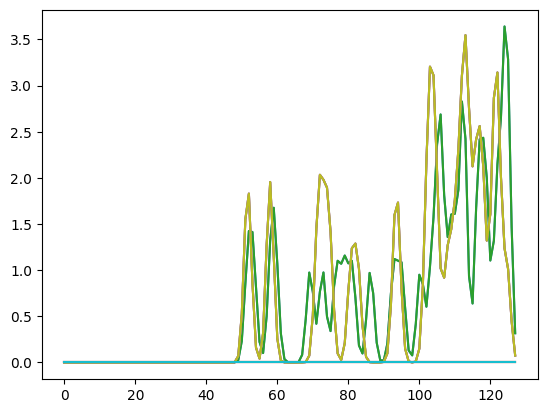

In [292]:
torch.manual_seed(0)
idx = torch.randint(len(rs_repr), size=(10,))
#idx = [10]
for i in idx:
    plt.plot(rs_repr[i//100][i%100].detach().numpy())
plt.show()
plt.close()

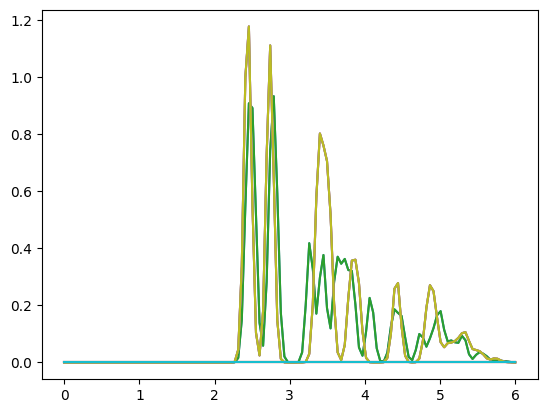

In [289]:
for i in idx:
    plt.plot(np.linspace(0, CUTOFF, 128), rs_repr[i//100][i%100].detach().numpy())
plt.show()
plt.close()

In [318]:
X = torch.cat(rs_repr)

In [319]:
y = torch.cat(ys)

In [320]:
print(X.shape)
print(y.shape)

torch.Size([825, 128])
torch.Size([825])


In [321]:
print(X.dtype)
print(y.dtype)

torch.float32
torch.float32


In [322]:
w = torch.linalg.lstsq(X, y).solution

In [325]:
Xnp = X.detach().numpy()
ynp = y.detach().numpy()

In [343]:
from sklearn.linear_model import RidgeCV, Ridge

In [350]:
ridge = Ridge(alpha=1e-3).fit(Xnp, ynp)
def loss_fn_numpy(pred, true):
    return np.sqrt(np.mean((pred - true)**2))

loss_fn_numpy(ridge.predict(Xnp), ynp)

0.14705949

In [344]:
for batch in train_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
X_train = torch.cat(rs_repr).detach().numpy()
y_train = torch.cat(ys).detach().numpy()

In [345]:
for batch in test_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
X_test = torch.cat(rs_repr).detach().numpy()
y_test = torch.cat(ys).detach().numpy()


In [351]:
loss_fn_numpy(ridge.predict(X_test), y_test)

0.18802598

In [323]:
loss_fn(X@w, y)

tensor(0.4225)

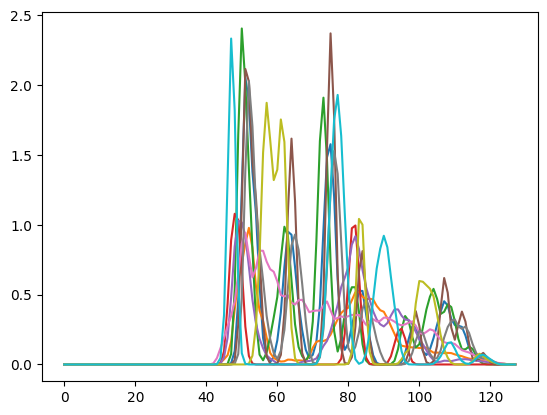

In [324]:
for i in torch.randint(len(X), size=(10,)):
    plt.plot(X[i].detach().numpy())
plt.show()
plt.close()

In [246]:
rs_embedding = []
ys = []
for batch in big_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_embedding(**batch)
    rs_embedding.append(x)
X = torch.cat(rs_embedding)

In [ ]:
for i in torch.randint(len(X), size=(10,)):
    plt.plot(X[i].detach().numpy())
plt.show()
plt.close()

In [ ]:
plt.plot(linear_embedding(torch.linspace(0,5,10)).detach().numpy().T) 
plt.show()
plt.close()

In [ ]:
plt.plot(linear_embedding(torch.linspace(0,5,10)).detach().numpy().sum(0)) 
plt.show()
plt.close()

In [ ]:
linear_embedding(torch.linspace(0,5,100)).shape

# Experiments

## Utils for experiment

In [426]:
def experiment(model, train_dataloader, val_dataloader, test_dataloader, n_epoch = 200, lr=0.01):
    
    for name, parameter in model.named_parameters():
        print(name)
        if "bias" in name:
            torch.nn.init.zeros_(parameter)
        else:
            torch.nn.init.xavier_uniform_(parameter)
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses_eVatom = []
    val_losses_eVatom = []
    test_losses_eVatom = []
    train_losses_eV = []
    val_losses_eV = []
    test_losses_eV = []
    
    for epoch_index in range(n_epoch):
        
        train_loss_eVatom = 0.
        train_loss_eV = 0.        
        for batch in train_dataloader:
            # Every data instance is an input + label pair
            y = batch.pop('scaled_dressed_energies_per_atom')
            nb_atoms = batch.pop('nb_atoms')
    
            # Zero your gradients for every batch!
            optimizer.zero_grad()
    
            # Make predictions for this batch
            y_pred = model.forward(**batch)
    
            # Compute the loss and its gradients
            sum_loss = loss_fn(y_pred, y)
            #loss = torch.mean(sum_loss)
            sum_loss.backward()
            train_loss_eVatom += sum_loss.item()
            train_loss_eV += torch.sum(((y_pred.detach() - y.detach())*nb_atoms)**2).item()
    
            # Adjust learning weights
            optimizer.step()
    
        train_loss_eVatom = np.sqrt(train_loss_eVatom / len(train_dataloader.dataset))
        train_losses_eVatom.append(train_loss_eVatom)
        train_loss_eV = np.sqrt(train_loss_eV / len(train_dataloader.dataset)) # loss per batch
        train_losses_eV.append(train_loss_eV)
    
        val_loss_eVatom = 0.
        val_loss_eV = 0.
        with torch.no_grad():
            for batch in val_dataloader:
                # Gather data and report
                y = batch.pop('scaled_dressed_energies_per_atom')
                nb_atoms = batch.pop('nb_atoms')
                y_pred = model.forward(**batch)
                sum_loss = loss_fn(y_pred, y)
                val_loss_eVatom += sum_loss.item()
                val_loss_eV += torch.sum(((y_pred.detach() - y.detach())*nb_atoms)**2).item()
                
        val_loss_eVatom = np.sqrt(val_loss_eVatom / len(val_dataloader.dataset))
        val_losses_eVatom.append(val_loss_eVatom)
        val_loss_eV = np.sqrt(val_loss_eV / len(val_dataloader.dataset)) # loss per batch
        val_losses_eV.append(val_loss_eV)
    
        
        test_loss_eVatom = 0.
        test_loss_eV = 0.
        with torch.no_grad():
            for batch in test_dataloader:
                # Gather data and report
                y = batch.pop('scaled_dressed_energies_per_atom')
                nb_atoms = batch.pop('nb_atoms')
                y_pred = model.forward(**batch)
                sum_loss = loss_fn(y_pred, y)
                test_loss_eVatom += sum_loss.item()
                test_loss_eV += torch.sum(((y_pred.detach() - y.detach())*nb_atoms)**2).item()
                
        test_loss_eVatom = np.sqrt(test_loss_eVatom / len(test_dataloader.dataset))
        test_losses_eVatom.append(test_loss_eVatom)
        test_loss_eV = np.sqrt(test_loss_eV / len(test_dataloader.dataset)) # loss per batch
        test_losses_eV.append(test_loss_eV)
                
        print(f"{epoch_index}"," {0:0.5f}".format(train_loss_eVatom), "{0:0.5f}".format(val_loss_eVatom), "{0:0.5f}".format(test_loss_eVatom))

    return train_losses_eVatom, val_losses_eVatom, test_losses_eVatom, train_losses_eV, val_losses_eV, test_losses_eV


In [347]:
def collate_nl_extended(data_list, device=None, dtype=None):

    collated = {key: torch.concatenate([data[key].to(device=device) for data in data_list], dim=0)
                for key in filter(lambda x : x not in ["positions", "cell"], data_list[0].keys())}
    collated['positions'] = torch.concatenate([data["positions"] for data in data_list]).to(dtype=dtype, device=device)
    collated['cells'] = torch.stack([data["cell"] for data in data_list]).to(dtype=dtype, device=device)
    collated['structure_centers'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["centers"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_pairs'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["pairs"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_offsets'] = torch.tensor(
        np.cumsum([0] + [structure_data["positions"].shape[0] for structure_data in data_list[:-1]]),
        device=collated["positions"][0].device,
        dtype=torch.long
    ).to(device=device)
    
    collated['nb_atoms'] =  torch.tensor(
        [structure_data["positions"].shape[0] for structure_data in data_list],
        device=collated["positions"][0].device,
        dtype=torch.long
    )
    return collated

collate_nl_extended_and_move = functools.partial(collate_nl_extended, dtype=DTYPE, device=DEVICE)

## Set up globals and dataset/loader

In [ ]:
CUTOFF = 6.
#torch.set_default_device("cuda:0")
DTYPE = torch.float32
DEVICE = "cuda"
collate_nl_and_move = functools.partial(collate_nl, dtype=DTYPE, device=DEVICE)

In [435]:
experiment_dataset = InMemoryDataset(frames,
                          [TransformerNeighborList(cutoff=CUTOFF, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=DTYPE)])
generator = torch.Generator().manual_seed(42)
train_experiment_dataset, val_experiment_dataset, test_experiment_dataset = torch.utils.data.random_split(experiment_dataset, [3/4*4/5, 3/4*1/5,1/4], generator=generator)
train_experiment_dataloader = torch.utils.data.DataLoader(train_experiment_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_extended_and_move, shuffle=True)
val_experiment_dataloader = torch.utils.data.DataLoader(val_experiment_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_extended_and_move, shuffle=True)
test_experiment_dataloader = torch.utils.data.DataLoader(test_experiment_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_extended_and_move, shuffle=True)


In [436]:
RESULTS = {}
NB_EXPERIMENTS = 3

## Spliney experiments

In [437]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=1,
                self_interaction=1,
                neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)
experiment_name = f"cutoff{CUTOFF}-spliney-layers_per_interaction{model._layers_per_interaction}-self_interaction{model._self_interaction}-neighbor_interaction{model._neighbor_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
0  0.26525 0.17532 0.17219
1  0.17562 0.13711 0.12844
2  0.13830 0.13156 0.12160
3  0.13080 0.11813 0.10417
4  0.11984 0.11173 0.09794
5  0.11308 0.10694 0.09524
6  0.10836 0.09866 0.09099
7  0.10215 0.09532 0.08843
8  0.09601 0.08707 0.08431
9  0.08884 0.08332 0.08663
10  0.08039 0.08674 0.09022
11  0.07851 0.06763 0.07209
12  0.06862 0.10099 0.10634
13  0.07558 0.06681 0.07049
14  0.06314 0.07491 0.08172
15  0.06699 0.07001 0.07396
16  0.06550 0.06452 0.06969
17  0.06711 0.05436 0.05954
18  0.05506 0.06210 0.06902
19  0.06081 0.06512 0.06915
20  0.05782 0.05272 0.05827
21  0.05392 0.05337 0.05840
22  0.05426 0.05256 0.05676
23  0.05267 0.05638 0.06009
24  0.05426 0.06051 0.06489
25  0.05837 0.05773 0.06067
26  0.05176 0.04936 0.

In [438]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=1,
                self_interaction=3,
                neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-spliney-layers_per_interaction{model._layers_per_interaction}-self_interaction{model._self_interaction}-neighbor_interaction{model._neighbor_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_self_interaction_linear_layers.1.weight
_self_interaction_linear_layers.1.bias
_self_interaction_linear_layers.2.weight
_self_interaction_linear_layers.2.bias
0  0.20396 0.19550 0.19394
1  0.18786 0.18319 0.17954
2  0.18053 0.17212 0.16610
3  0.16095 0.14171 0.13468
4  0.13654 0.12125 0.11923
5  0.13581 0.12591 0.12801
6  0.12718 0.11900 0.11652
7  0.12250 0.12884 0.12154
8  0.12530 0.10999 0.10573
9  0.11381 0.10978 0.10836
10  0.11437 0.10957 0.11503
11  0.10812 0.10895 0.10589
12  0.10651 0.10202 0.10655
13  0.10526 0.11886 0.11348
14  0.11758 0.12383 0.15672
15  0.11285 0.12392 0.

In [439]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=1,
                self_interaction=1,
                neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-spliney-layers_per_interaction{model._layers_per_interaction}-self_interaction{model._self_interaction}-neighbor_interaction{model._neighbor_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0  0.19310 0.19127 0.18943
1  0.17751 0.16645 0.16145
2  0.15386 0.12340 0.10976
3  0.12386 0.10618 0.09545
4  0.11020 0.11159 0.11775
5  0.10488 0.09335 0.09094
6  0.08780 0.06896 0.07857
7  0.07473 0.09504 0.10366
8  0.07974 0.07537 0.08642
9  0.06854 0.07329 0.08295
10  0.06655 0.05569 0.06260
11  0.05808 0.08122 0.08661
12  0.06315 0.05281 0.05899
13  0.05639 0.06001 0.06612
14  0.05456 0.05959 0.06570
15  0.05864 0.05244 0.05721
16  0.05261 0.05307 0.05760
17  0.04962 0.04949 0.05282
18  0.05233 0.04865 0.05152
19  0.05030 0.04967 0.05133
20  0.04861 0.04806 

In [440]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=4,
                self_interaction=0,
                neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-spliney-layers_per_interaction{model._layers_per_interaction}-self_interaction{model._self_interaction}-neighbor_interaction{model._neighbor_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_layers.3.0.weight
_layers.3.0.bias
_output_layer.weight
_output_layer.bias
0  2.39990 0.20637 0.20601
1  0.53869 0.33500 0.33309
2  0.27516 0.18868 0.18721
3  0.18923 0.17037 0.16740
4  0.15742 0.13931 0.13305
5  0.14228 0.12999 0.12199
6  0.13350 0.12241 0.11324
7  0.12637 0.11610 0.10606
8  0.12003 0.11110 0.10066
9  0.11460 0.10657 0.09622
10  0.11060 0.10728 0.09769
11  0.10807 0.10251 0.09377
12  0.10673 0.10481 0.09665
13  0.10463 0.09864 0.09291
14  0.10212 0.09555 0.08968
15  0.10012 0.09446 0.08970
16  0.09875 0.09312 0.08842
17  0.09741 0.09553 0.09086
18  0.10129 0.12388 0.11883
19  0.09961 0.10715 0.10694
20  0.09826 0.11328 0.10901
21  0.10005 0.08763 0.08510
22  0.09280 0.10216 0.10306
23  0.09470 0.08470 0.08389
24  0.08871 0.08704 0.08578
25  0.08859 0.08641 0.08494
26  0.08691 0.08494 0.08702
27  0.08669 0.08273 0.08531
28  0.09117 

## RadialSpectrum experiments

In [441]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128,
                       layers_per_interaction=0,
                       dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-radialspectrum-layers_per_interaction{model._layers_per_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias
0  0.28301 0.18005 0.16697
1  0.15915 0.12158 0.11500
2  0.12449 0.10233 0.10699
3  0.10969 0.09156 0.09871
4  0.09874 0.08107 0.08509
5  0.08931 0.07492 0.08128
6  0.08299 0.06912 0.07512
7  0.07705 0.06460 0.07052
8  0.07186 0.06087 0.06640
9  0.06831 0.05938 0.06383
10  0.06626 0.05712 0.06153
11  0.06306 0.05906 0.06381
12  0.06504 0.07342 0.07549
13  0.06495 0.06222 0.06706
14  0.06084 0.05261 0.05568
15  0.05705 0.05013 0.05373
16  0.05525 0.05080 0.05387
17  0.05480 0.04949 0.05324
18  0.05408 0.05127 0.05422
19  0.05591 0.05259 0.05615
20  0.05340 0.05175 0.05430
21  0.05265 0.04790 0.05103
22  0.05493 0.04680 0.04980
23  0.05126 0.04693 0.04975
24  0.05121 0.04717 0.04993
25  0.05233 0.04684 0.04901
26  0.05082 0.04618 0.04836
27  0.05060 0.04843 0.05115
28  0.05072 0.05873 0.06044
29  0.05447 0.04665 0.04962
30  0.05138 0.04620 0.04789
31  0.05084 0.04756 0.04876
32  0.05034 0.04760 0.05013
33  0.05016 0.04

In [442]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128,
                       layers_per_interaction=3,
                       dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-radialspectrum-layers_per_interaction{model._layers_per_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_output_layer.weight
_output_layer.bias
0  0.34817 0.12622 0.11873
1  0.12828 0.10811 0.10487
2  0.10085 0.08461 0.08517
3  0.08471 0.07170 0.07239
4  0.07153 0.06229 0.06440
5  0.06375 0.06535 0.06642
6  0.05844 0.05366 0.05402
7  0.05263 0.05360 0.05352
8  0.04922 0.05329 0.05296
9  0.05428 0.07889 0.07954
10  0.05888 0.04976 0.04859
11  0.05101 0.07074 0.07080
12  0.05316 0.04747 0.04623
13  0.04307 0.05197 0.05032
14  0.04160 0.04722 0.04622
15  0.03878 0.04247 0.04117
16  0.03794 0.04708 0.04528
17  0.03853 0.05002 0.05002
18  0.04036 0.05397 0.05271
19  0.04205 0.06505 0.06333
20  0.04462 0.04502 0.04312
21  0.03730 0.03996 0.03828
22  0.03291 0.05407 0.05422
23  0.03775 0.05081 0.05071
24  0.03934 0.03984 0.03901
25  0.03299 0.04494 0.04239
26  0.03178 0.03901 0.03657
27  0.03278 0.04258 0.04018
28  0.03338 0.04099 0.03968
29  0.03447 0.03837 

In [443]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128,
                       layers_per_interaction=6,
                       dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-radialspectrum-layers_per_interaction{model._layers_per_interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=200)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_layers.3.0.weight
_layers.3.0.bias
_layers.4.0.weight
_layers.4.0.bias
_layers.5.0.weight
_layers.5.0.bias
_output_layer.weight
_output_layer.bias
0  0.24756 0.14410 0.13567
1  0.13814 0.11090 0.10665
2  0.10960 0.10720 0.11335
3  0.08028 0.06963 0.06742
4  0.07176 0.08594 0.08472
5  0.06892 0.08165 0.08169
6  0.06509 0.05064 0.05007
7  0.04914 0.04947 0.04811
8  0.04662 0.04945 0.04966
9  0.04532 0.04786 0.04768
10  0.04396 0.04612 0.04598
11  0.04156 0.04735 0.04711
12  0.03967 0.04684 0.04729
13  0.04271 0.04991 0.05028
14  0.03913 0.04004 0.03990
15  0.03702 0.04178 0.04051
16  0.03688 0.04565 0.04475
17  0.03572 0.04425 0.04254
18  0.03452 0.03896 0.03745
19  0.03364 0.05578 0.05410
20  0.03991 0.03817 0.03698
21  0.03233 0.03937 0.04006
22  0.03033 0.03768 0.03756
23  0.02950 0.03733 0.03559
24  0.02946 0.04432 0.04417
25  0.03200 0.04667 0.04

## PointEdge experiments

In [444]:
model = PointEdge(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, interaction=0,
                dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-pointedge-layers_per_interaction{model._layers_per_interaction}-interaction{model._interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=400, lr=0.001)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layer_linear.weight
_layer_linear.bias
_center_layers.0.0.weight
_center_layers.0.0.bias
_center_layer_linear.weight
_center_layer_linear.bias
_output_layer.weight
_output_layer.bias
0  0.38303 0.30941 0.30764
1  0.28462 0.24129 0.23928
2  0.23073 0.20555 0.20445
3  0.20164 0.18403 0.18393
4  0.18422 0.16952 0.16971
5  0.17206 0.16021 0.16040
6  0.16358 0.15381 0.15391
7  0.15774 0.14887 0.14878
8  0.15329 0.14507 0.14472
9  0.14973 0.14167 0.14110
10  0.14652 0.13859 0.13759
11  0.14352 0.13607 0.13475
12  0.14086 0.13329 0.13162
13  0.13841 0.13073 0.12881
14  0.13579 0.12877 0.12658
15  0.13354 0.12646 0.12388
16  0.13134 0.12449 0.12175
17  0.12902 0.12237 0.11942
18  0.12677 0.12031 0.11720
19  0.12482 0.11842 0.11508
20  0.12289 0.11702 0.11355
21  0.12101 0.11529 0.11176
22  0.11935 0.11373 0.11008
23  0.11750 0.11177 0.10812
24  0.11604 0.11052 0.10684
25  0.11430 0.10896 0.10514
26  0.11287 0.10814 0.10436
27  

In [445]:
model = PointEdge(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, interaction=3,
                dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-pointedge-layers_per_interaction{model._layers_per_interaction}-interaction{model._interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=400, lr=0.001)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layer_linear.weight
_layer_linear.bias
_center_layers.0.0.weight
_center_layers.0.0.bias
_center_layer_linear.weight
_center_layer_linear.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.1.0.0.weight
_neighbor_interaction_layers.1.0.0.bias
_neighbor_interaction_layers.2.0.0.weight
_neighbor_interaction_layers.2.0.0.bias
_center_interaction_layers.0.0.0.weight
_center_interaction_layers.0.0.0.bias
_center_interaction_layers.1.0.0.weight
_center_interaction_layers.1.0.0.bias
_center_interaction_layers.2.0.0.weight
_center_interaction_layers.2.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_i

In [446]:
model = PointEdge(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, interaction=6,
                dtype=DTYPE, device=DEVICE)

experiment_name = f"cutoff{CUTOFF}-pointedge-layers_per_interaction{model._layers_per_interaction}-interaction{model._interaction}"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=400, lr=0.001)

_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layer_linear.weight
_layer_linear.bias
_center_layers.0.0.weight
_center_layers.0.0.bias
_center_layer_linear.weight
_center_layer_linear.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_self_interaction_layers.3.0.0.weight
_self_interaction_layers.3.0.0.bias
_self_interaction_layers.4.0.0.weight
_self_interaction_layers.4.0.0.bias
_self_interaction_layers.5.0.0.weight
_self_interaction_layers.5.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.1.0.0.weight
_neighbor_interaction_layers.1.0.0.bias
_neighbor_interaction_layers.2.0.0.weight
_neighbor_interaction_layers.2.0.0.bias
_neighbor_interaction_layers.3.0.0.weight
_neighbor_interaction_layers.3.0.0.bias
_neighbor_interact

## SchNet experiments

In [447]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=0,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)
experiment_name = f"cutoff{CUTOFF}-schnet-n_interactions0"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=400, lr=0.001)

embedding.weight
_output_module.weight
_output_module.bias
0  0.21242 0.19926 0.19756
1  0.20908 0.20089 0.19995
2  0.20901 0.19943 0.19810
3  0.20890 0.20023 0.19916
4  0.20895 0.19931 0.19758
5  0.20909 0.20067 0.19970
6  0.20929 0.19918 0.19765
7  0.20893 0.20036 0.19932
8  0.20911 0.19995 0.19881
9  0.20888 0.19947 0.19816
10  0.20906 0.19965 0.19841
11  0.20915 0.20101 0.20010
12  0.20971 0.20028 0.19922
13  0.20901 0.19923 0.19778
14  0.20903 0.20153 0.20071
15  0.20928 0.19930 0.19789
16  0.20938 0.19919 0.19757
17  0.20923 0.19918 0.19759
18  0.20961 0.19921 0.19756
19  0.21017 0.19969 0.19847
20  0.20995 0.20273 0.20209
21  0.20949 0.19955 0.19828
22  0.20895 0.19941 0.19807
23  0.20989 0.20238 0.20170
24  0.20911 0.19934 0.19796
25  0.20912 0.19983 0.19865
26  0.20922 0.20082 0.19988
27  0.20911 0.19940 0.19806
28  0.20887 0.19940 0.19805
29  0.20893 0.19998 0.19884
30  0.20909 0.20066 0.19969
31  0.21023 0.20519 0.20485
32  0.21006 0.20006 0.19808
33  0.20967 0.19941 0.19808

In [448]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=3,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)
experiment_name = f"cutoff{CUTOFF}-schnet-n_interactions3"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=400, lr=0.001)

embedding.weight
interactions.0.in2f.weight
interactions.0.f2out.0.weight
interactions.0.f2out.0.bias
interactions.0.f2out.1.weight
interactions.0.f2out.1.bias
interactions.0.filter_network.0.weight
interactions.0.filter_network.0.bias
interactions.0.filter_network.1.weight
interactions.0.filter_network.1.bias
interactions.1.in2f.weight
interactions.1.f2out.0.weight
interactions.1.f2out.0.bias
interactions.1.f2out.1.weight
interactions.1.f2out.1.bias
interactions.1.filter_network.0.weight
interactions.1.filter_network.0.bias
interactions.1.filter_network.1.weight
interactions.1.filter_network.1.bias
interactions.2.in2f.weight
interactions.2.f2out.0.weight
interactions.2.f2out.0.bias
interactions.2.f2out.1.weight
interactions.2.f2out.1.bias
interactions.2.filter_network.0.weight
interactions.2.filter_network.0.bias
interactions.2.filter_network.1.weight
interactions.2.filter_network.1.bias
_output_module.weight
_output_module.bias
0  0.15898 0.11080 0.10507
1  0.10634 0.09673 0.09485
2 

In [449]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)
experiment_name = f"cutoff{CUTOFF}-schnet-n_interactions6"
RESULTS[experiment_name] = {}
for i in range(NB_EXPERIMENTS):
    RESULTS[experiment_name][f"experiment_{i}"] = \
                experiment(model, train_experiment_dataloader, val_experiment_dataloader, test_experiment_dataloader, n_epoch=400, lr=0.001)

embedding.weight
interactions.0.in2f.weight
interactions.0.f2out.0.weight
interactions.0.f2out.0.bias
interactions.0.f2out.1.weight
interactions.0.f2out.1.bias
interactions.0.filter_network.0.weight
interactions.0.filter_network.0.bias
interactions.0.filter_network.1.weight
interactions.0.filter_network.1.bias
interactions.1.in2f.weight
interactions.1.f2out.0.weight
interactions.1.f2out.0.bias
interactions.1.f2out.1.weight
interactions.1.f2out.1.bias
interactions.1.filter_network.0.weight
interactions.1.filter_network.0.bias
interactions.1.filter_network.1.weight
interactions.1.filter_network.1.bias
interactions.2.in2f.weight
interactions.2.f2out.0.weight
interactions.2.f2out.0.bias
interactions.2.f2out.1.weight
interactions.2.f2out.1.bias
interactions.2.filter_network.0.weight
interactions.2.filter_network.0.bias
interactions.2.filter_network.1.weight
interactions.2.filter_network.1.bias
interactions.3.in2f.weight
interactions.3.f2out.0.weight
interactions.3.f2out.0.bias
interactions.

## Save results

In [450]:
np.savez("results.npz", RESULTS)

# Analyze results

In [451]:
results = np.load('results.npz', allow_pickle=True)
results = results['arr_0'].tolist()

### Spliney results

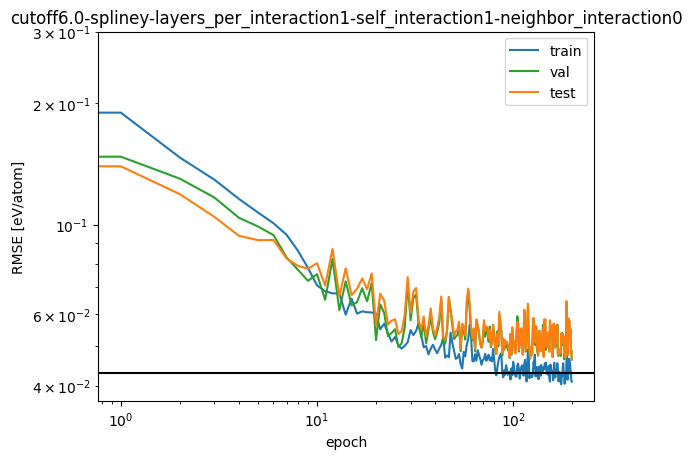

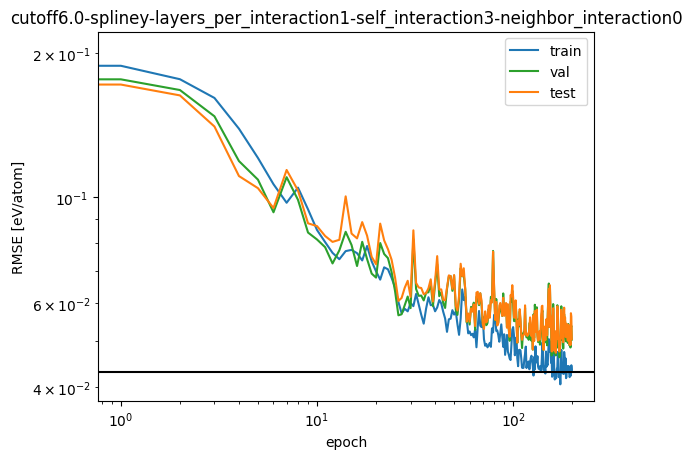

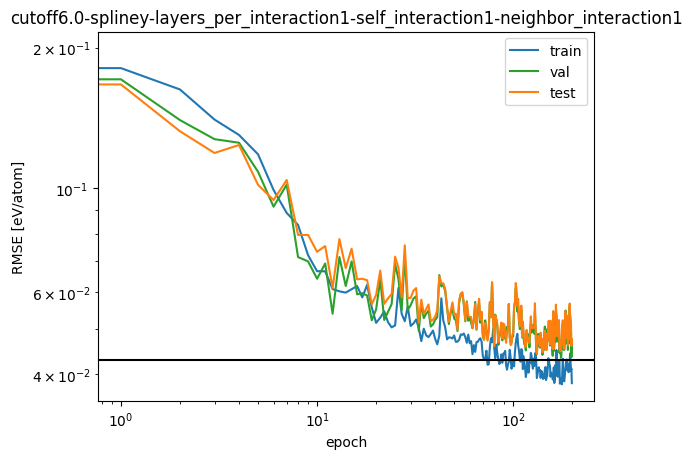

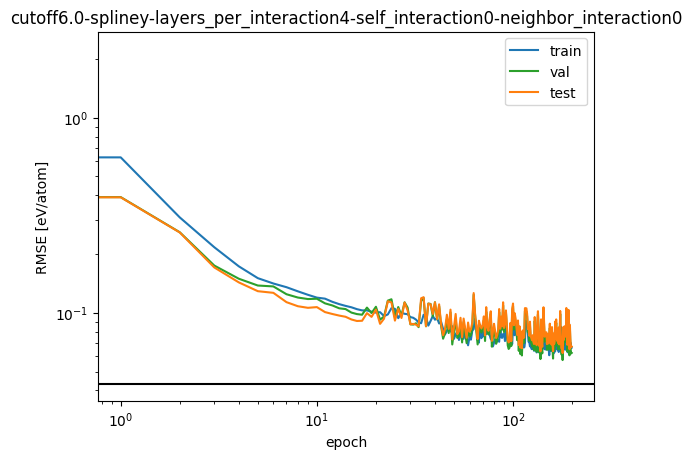

In [452]:
for experiment_name, result in results.items():
    if "spliney" not in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)
    std_error = np.std(list(result.values()), axis=0)
    
    plt.loglog(mean_error[0], label='train')
    plt.loglog(mean_error[1], label='val', color='C2')
    plt.loglog(mean_error[2], label='test', color='C1')
    plt.title(f"{experiment_name}")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
    plt.legend()
    plt.show()
    plt.close()
#print("---------------------------------------------")
#print("--------------------EV-----------------------)
#print("---------------------------------------------")
#for experiment_name, result in results.items():
#    plt.loglog(mean_error[3], label='train')
#    plt.loglog(mean_error[4], label='val', color='C2')
#    plt.loglog(mean_error[5], label='test', color='C1')
#    plt.title(f"{experiment_name}")
#    plt.ylabel("RMSE [eV]")
#    plt.xlabel("epoch")
#    plt.axhline(0.043, color='black')
#    plt.legend()
#    plt.show()
#    plt.close()


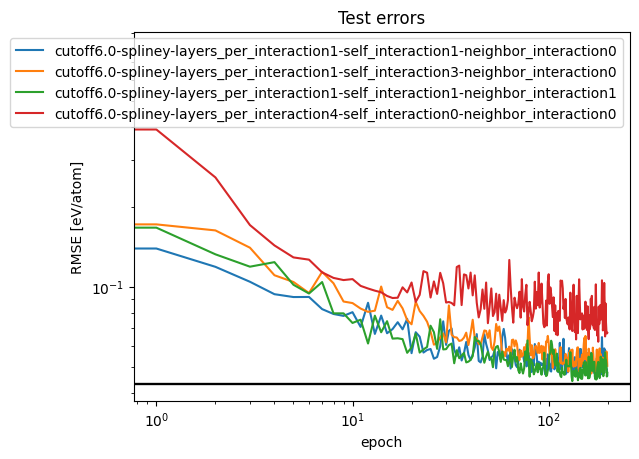

In [453]:
for experiment_name, result in results.items():
    if "spliney" not in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)
    std_error = np.std(list(result.values()), axis=0)    
    plt.loglog(mean_error[2], label=f'{experiment_name}')
    plt.title(f"Test errors")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

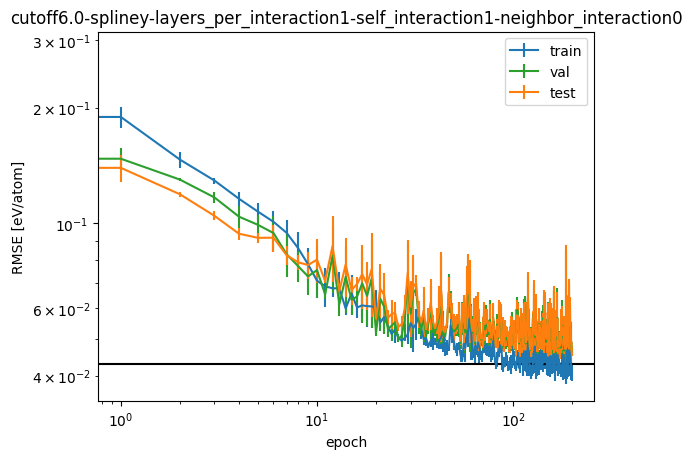

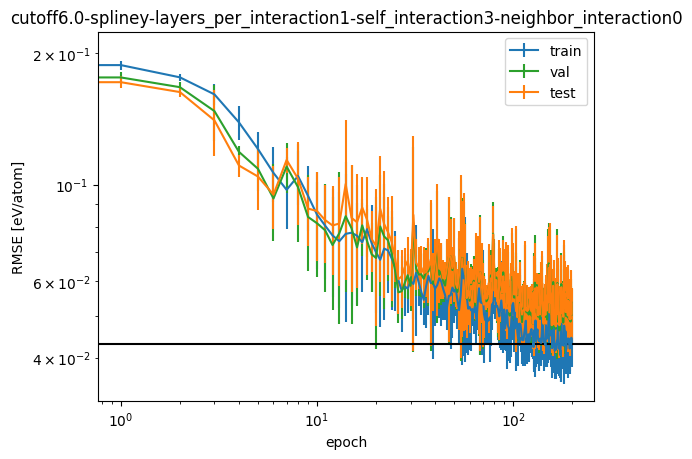

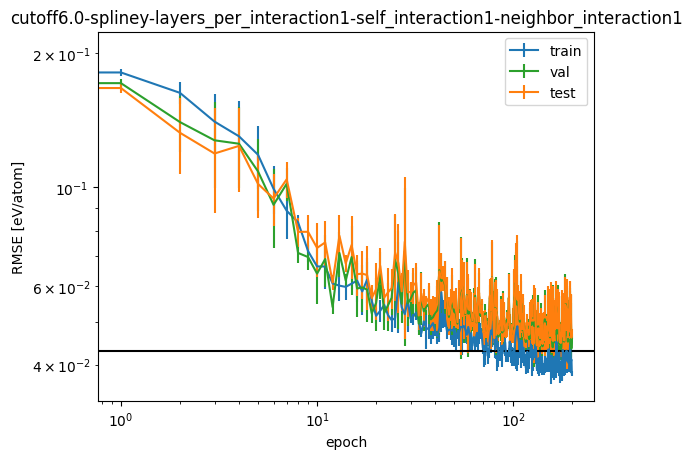

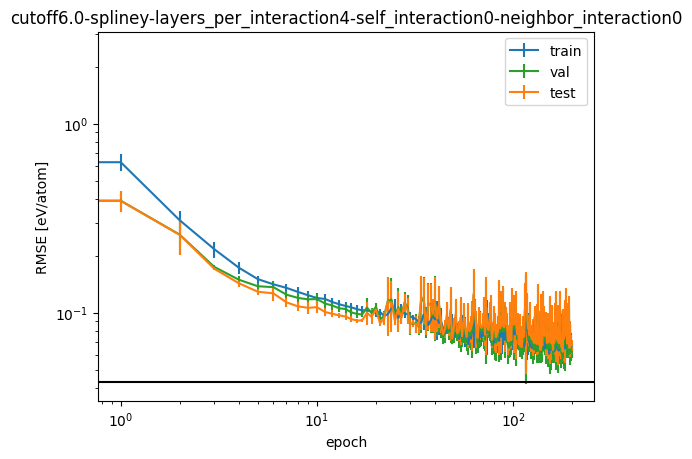

In [456]:
for experiment_name, result in results.items():
    if "spliney" not in experiment_name:
        continue    
    mean_error = np.mean(list(result.values()), axis=0)
    std_error = np.std(list(result.values()), axis=0)
    plt.errorbar(np.arange(mean_error[0].shape[0]), mean_error[0], yerr=std_error[0], label='train')
    plt.errorbar(np.arange(mean_error[1].shape[0]), mean_error[1], yerr=std_error[1], label='val', color='C2')
    plt.errorbar(np.arange(mean_error[2].shape[0]), mean_error[2], yerr=std_error[2], label='test', color='C1')
    plt.title(f"{experiment_name}")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    plt.close()

## Radial spectrum results

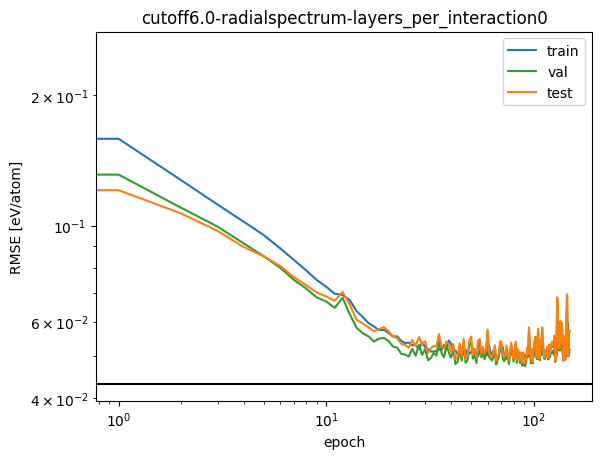

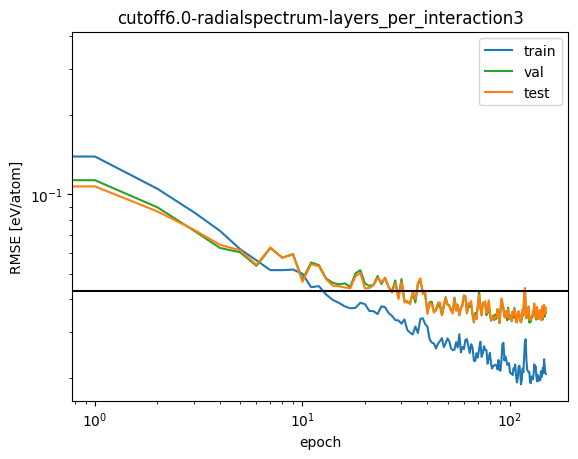

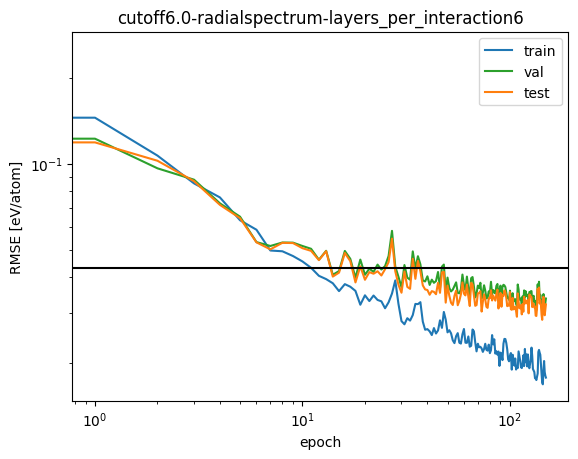

In [459]:
for experiment_name, result in results.items():
    if "radialspectrum" not in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)[:, :150]
    std_error = np.std(list(result.values()), axis=0)[:, :150]
    
    plt.loglog(mean_error[0], label='train')
    plt.loglog(mean_error[1], label='val', color='C2')
    plt.loglog(mean_error[2], label='test', color='C1')
    plt.title(f"{experiment_name}")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
    plt.legend()
    plt.show()
    plt.close()

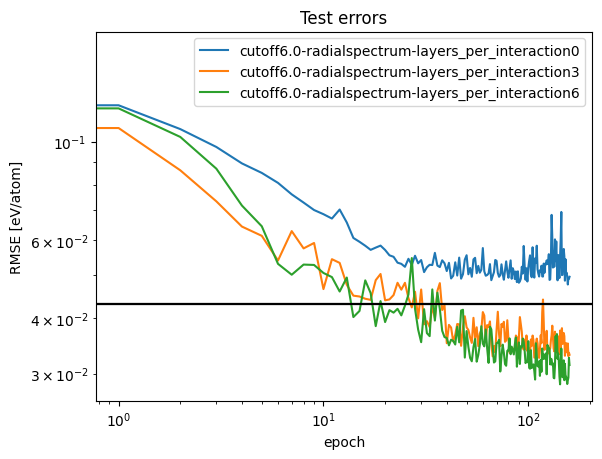

In [462]:
for experiment_name, result in results.items():
    if "radialspectrum" not in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)[:, :160]
    std_error = np.std(list(result.values()), axis=0)[:, :160]
    plt.loglog(mean_error[2], label=f'{experiment_name}')
    plt.title(f"Test errors")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()


## PointEdge results

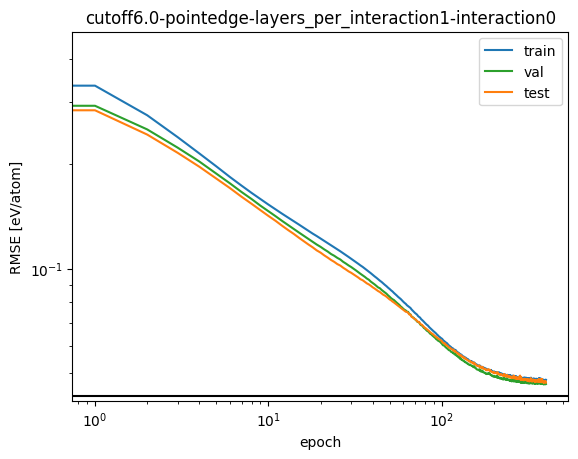

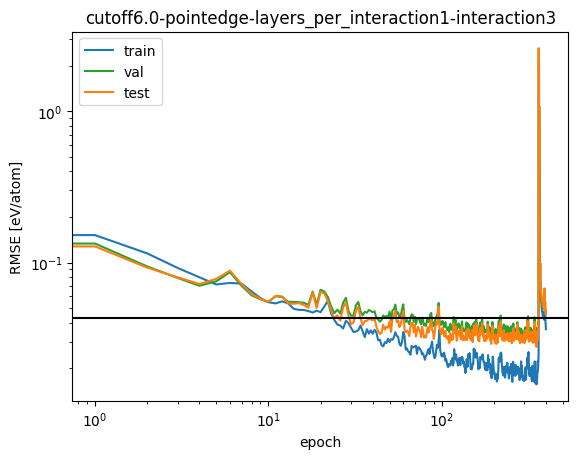

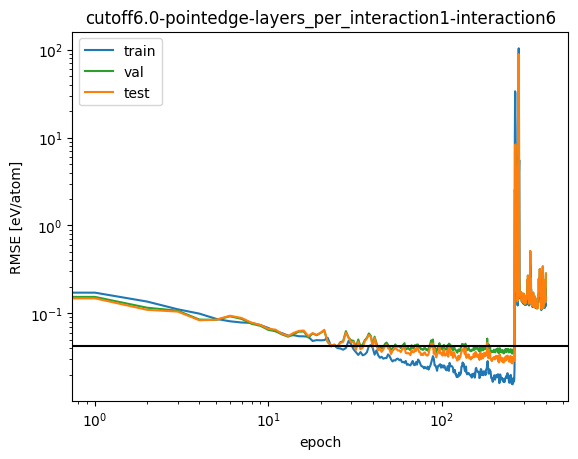

In [466]:
for experiment_name, result in results.items():
    if "pointedge" not in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)
    std_error = np.std(list(result.values()), axis=0)
    
    plt.loglog(mean_error[0], label='train')
    plt.loglog(mean_error[1], label='val', color='C2')
    plt.loglog(mean_error[2], label='test', color='C1')
    plt.title(f"{experiment_name}")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
    plt.legend()
    plt.show()
    plt.close()

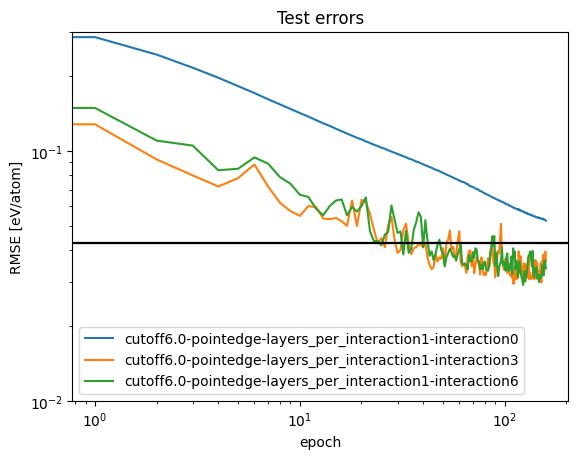

In [494]:
for experiment_name, result in results.items():
    if "pointedge" not in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)[:, :160]
    std_error = np.std(list(result.values()), axis=0)[:, :160]
    plt.loglog(mean_error[2], label=f'{experiment_name}')
    plt.title(f"Test errors")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
plt.legend()
plt.ylim(0.01, 0.3)
plt.show()
plt.close()


## SchNet results

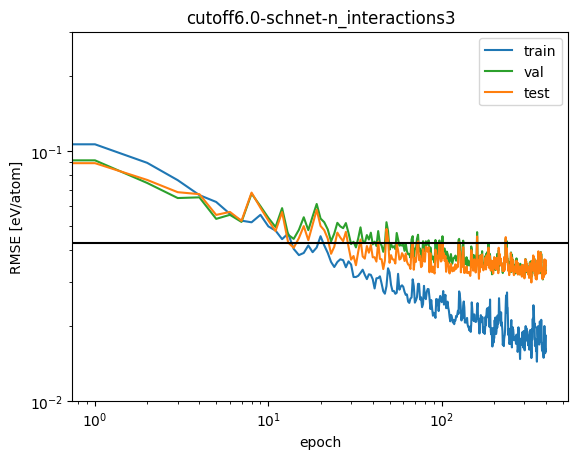

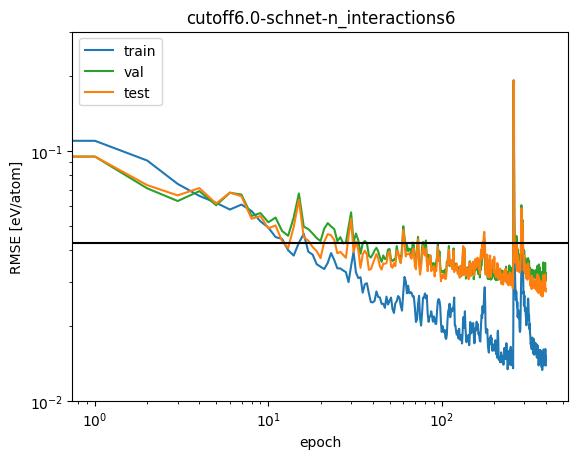

In [496]:
for experiment_name, result in results.items():
    if "schnet" not in experiment_name or "interactions0" in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)
    std_error = np.std(list(result.values()), axis=0)
    
    plt.loglog(mean_error[0], label='train')
    plt.loglog(mean_error[1], label='val', color='C2')
    plt.loglog(mean_error[2], label='test', color='C1')
    plt.title(f"{experiment_name}")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
    plt.legend()
    plt.ylim(0.01, 0.3)
    plt.show()
    plt.close()

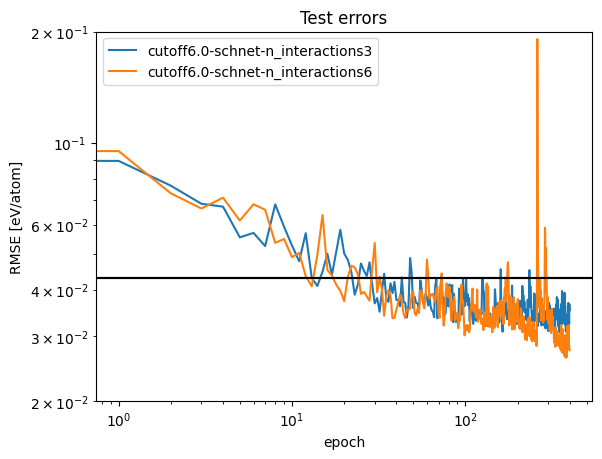

In [488]:
for experiment_name, result in results.items():
    if "schnet" not in experiment_name or "interactions0" in experiment_name:
        continue
    mean_error = np.mean(list(result.values()), axis=0)[:, :]
    std_error = np.std(list(result.values()), axis=0)[:, :]
    plt.loglog(mean_error[2], label=f'{experiment_name}')
    plt.title(f"Test errors")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
plt.legend()
    plt.ylim(0.01, 0.2)
plt.show()
plt.close()


## All results

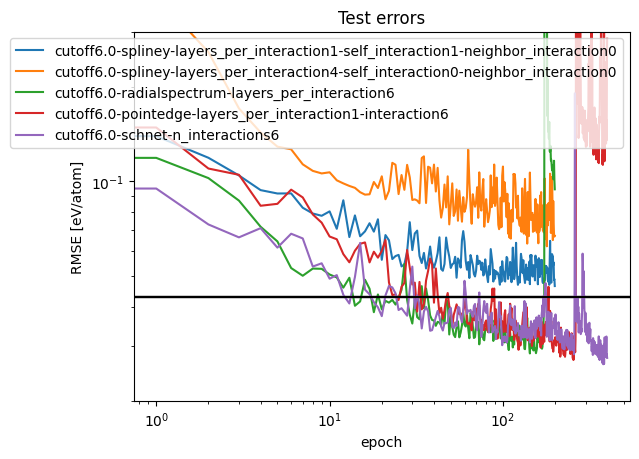

In [499]:
for experiment_name, result in results.items():
    if experiment_name not in [
                            "cutoff6.0-spliney-layers_per_interaction4-self_interaction0-neighbor_interaction0",
                           "cutoff6.0-spliney-layers_per_interaction1-self_interaction1-neighbor_interaction0",
                           "cutoff6.0-radialspectrum-layers_per_interaction6",
                           "cutoff6.0-pointedge-layers_per_interaction1-interaction6",
                           "cutoff6.0-schnet-n_interactions6"]:
        continue
    mean_error = np.mean(list(result.values()), axis=0)[:, :]
    std_error = np.std(list(result.values()), axis=0)[:, :]
    plt.loglog(mean_error[2], label=f'{experiment_name}')
    plt.title(f"Test errors")
    plt.ylabel("RMSE [eV/atom]")
    plt.xlabel("epoch")
    plt.axhline(0.043, color='black')
plt.ylim(0.02, 0.3)
plt.legend()
plt.show()c
plt.close()
